# Observation: 2D

## Quickly inspect data

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

ds = xr.open_dataset('../data/sst.mnmean.nc')  # ERSSTv5 typically has lon 0..360
ds.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 132MB
Dimensions:    (lat: 89, lon: 180, time: 2059, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 33kB ...
    sst        (time, lat, lon) float32 132MB ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ..

In [4]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
# %matplotlib inline

%output holomap='scrubber' fps=3
ds.sst.hvplot('lon', 'lat', cmap='RdBu_r').redim.range(sst=(-2, 30))

/tmp/ipykernel_2984893/1422216783.py:6: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [lon,lat]   (Monthly Means of Sea Surface Temperature)

## PCA

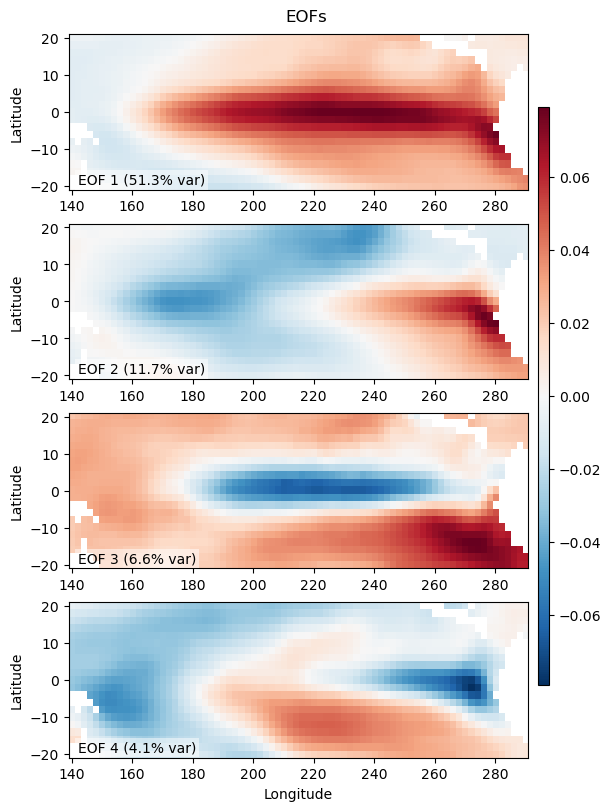

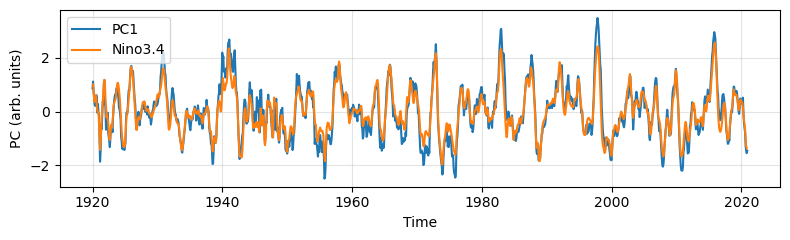

In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
from eofs.xarray import Eof

def pca_ersstv5(
    da,
    time_slice=None,        # e.g. ("1900-01", "2024-12")
    lat_bounds=None,        # e.g. (60, -60)
    lon_bounds=None,        # e.g. (120, 290)   (0..360 in ERSST)
    remove_season=True,
    detrend_linear=False,
    n_modes=10,
    reorder_lat_ascending=False,
    nino=False,
    clim_ref=None,
):
    # ---- (Optional) reorder latitude to ascending; safer for weighting/plots ---
    if reorder_lat_ascending and (da.lat.values[0] > da.lat.values[-1]):
        da = da.sortby("lat")

    # ---- Subset time ----
    if time_slice is not None:
        da = da.sel(time=slice(*time_slice))

    # ---- Subset latitude ----
    if lat_bounds is not None:
        lo, hi = lat_bounds
        da = da.sel(lat=slice(lo, hi))

    # ---- Subset longitude ----
    if lon_bounds is not None:
        lo, hi = lon_bounds
        if lo <= hi:
            da = da.sel(lon=slice(lo, hi))
        else:
            # wrap-around case, e.g. (300, 60)
            da = xr.concat(
                [da.sel(lon=slice(lo, 360)), da.sel(lon=slice(0, hi))],
                dim="lon"
            )

    # ---- Remove seasonal cycle (monthly climatology) ----
    if remove_season:
        if clim_ref is None:
            clim = da.groupby("time.month").mean("time")
        else:
            ref = da.sel(time=slice(*clim_ref)) # Select the reference period for climatology
            if ref.time.size == 0:
                raise ValueError(f"clim_ref range {clim_ref} has no overlap with data.")
            clim = ref.groupby("time.month").mean("time") # Compute monthly climatology over the reference period
        anoms = da.groupby("time.month") - clim # Subtract monthly climatology from all time steps
    else:
        anoms = da        

    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )
    
    # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    lat_rad = np.deg2rad(anoms["lat"])
    w_lat = np.cos(lat_rad)
    w2d = w_lat.broadcast_like(anoms.isel(time=0)) # Expand to 2D (lat, lon) for clean broadcasting

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = (anoms*w2d).sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=('lon', 'lat'))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
        
    # anoms_w = anoms * np.sqrt(w2d)
    # anoms_w = anoms_w[:, np.isfinite(anoms_w).all("time")]
    # anoms_w.mean(dim=['lon', 'lat']).plot(label='detrended')
    # plt.grid()
    # plt.legend()

    solver = Eof(anoms.transpose("time", "lat", "lon"), weights=np.sqrt(w2d))
    EOFs = solver.eofs(neofs=n_modes)
    PCs = solver.pcs(npcs=n_modes, pcscaling=1)
    evrs = solver.varianceFraction()
    EOFs = EOFs.assign_coords(mode=np.arange(1, EOFs.sizes["mode"]+1))

    out = {
        "EOFs": EOFs,  # [mode, lat, lon] in °C units
        "PCs": xr.DataArray(PCs, coords={"time": anoms["time"], "mode": np.arange(1, n_modes+1)}, dims=["time","mode"]),
        "evrs": xr.DataArray(evrs[:n_modes], coords={"mode": np.arange(1, n_modes+1)}, dims=["mode"]),
        # "singular_values": s[:k],
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

def plot_eofs(eofs, evr, modes=(1,2,3), vmin=None, vmax=None):
    modes = list(modes)
    fig, axs = plt.subplots(len(modes), 1, figsize=(6, 2*len(modes)), constrained_layout=True)
    if len(modes) == 1: axs = [axs]
    for ax, m in zip(axs, modes):
        patt = eofs.sel(mode=m)
        patt = patt.sortby("lat")
        im = patt.plot.imshow(
            ax=ax, cmap="RdBu_r", vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        ax.set_title("")
        ax.text(
            0.02, 0.02, f"EOF {m} ({evr.sel(mode=m).item()*100:.1f}% var)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("EOFs", fontsize=12)
def plot_pcs(pcs, modes=(1,2,3), nino=None):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    for m in modes:
        ax.plot(pcs["time"].values, pcs.sel(mode=m), label=f"PC{m}")
    if nino is not None:
        ax.plot(nino["time"].values, nino, label=f"Nino3.4")
    ax.legend()
    ax.grid(True, alpha=0.35)
    ax.set_xlabel("Time")
    ax.set_ylabel("PC (arb. units)")
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    #ds = xr.open_dataset("../ENSO-data/data/sst.mnmean.nc")
    ds = xr.open_dataset("../data/sst.mnmean.nc")
    da = ds["sst"]  # ERSSTv5: 'sst'
    res = pca_ersstv5(
        da,
        time_slice=("1920-01", "2020-12"),
        lat_bounds=(20, -20),
        lon_bounds=(140, 290),
        remove_season=True,
        detrend_linear=True,
        n_modes=4,
        nino=True,
        clim_ref=("1981-01", "2010-12"),
    )

    plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
    # plt.savefig('../figure/eofs.png')
    plot_pcs(res["PCs"], modes=(1,), nino=res['nino34'])

In [13]:
ds_out = xr.Dataset(
    data_vars={
        "EOFs":   res["EOFs"],     # (mode, lat, lon)
        "PCs":    res["PCs"],      # (time, mode)
        "EVRs":    res["evrs"],     # (mode)
        "Nino34": res["nino34"],   # (time)
        "anoms":   res["anoms"],    # (time, lat, lon) anomalies used in EOFs
    }
)
ds_out.attrs.update({
    "title": "ERSSTv5 EOF/PCA and Niño 3.4",
    "climatology_ref": "1981-01 to 2010-12",
    "notes": "EOFs computed with eofs.xarray, weights = sqrt(cos(lat))",
})

out_path = "../data/ersstv5_eof_nino34_1920_2020.nc"
ds_out.to_netcdf(out_path, format="NETCDF4")
print(f"Saved to {out_path}")

Saved to ../data/ersstv5_eof_nino34_1920_2020.nc


In [17]:
res["PCs"].to_numpy().shape

(1212, 4)

## Clustering

### FCM

In [35]:
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy
from time import time
import pickle

def reorder_labels_by_mean_nino34(nino34, labels):
    """
    Reorder integer labels so that the highest-mean Niño 3.4
    regime is label 0, next highest is label 1, etc.
    """
    labels = np.asarray(labels)
    nino34 = np.asarray(nino34)

    unique_labels = np.unique(labels)
    means = {lab: np.nanmean(nino34[labels == lab]) for lab in unique_labels}

    # Sort regime IDs by descending mean Niño 3.4
    sorted_labs = sorted(unique_labels, key=lambda x: means[x], reverse=True)

    # Map old label -> new label (0, 1, 2, ...)
    remap = {old: new for new, old in enumerate(sorted_labs)}
    new_labels = np.array([remap[lab] for lab in labels])

    return new_labels, remap, means
    
np.random.seed(0)

########################## load data ############################
file = xr.open_dataset("../data/ersstv5_eof_nino34_1920_2020.nc")
data = file["PCs"].to_numpy()
nino34 = file["Nino34"].to_numpy()
train_size = 1212 # training data size
test_size = 0 # test data size

######################### clustering ############################
K = 5 # number of clusters (regimes)
L = 0 # time delay steps
data = data[:train_size]
Nt, _ = data.shape
features = []
features.append(data)
data_embedded = np.concatenate(features, axis=1)

# standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_embedded)

# clustering
cluster_model = FCMEntropy(num_clusters=K, m=1.8, lambda_e=.2, num_steps=1000, seed=0)
results = cluster_model.fit(data_scaled, optimizer='iterative')
membership = results['membership']
centers = results['centers']
labels = np.argmax(membership, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

# save the clustering model
fcm_model_data = {
    'centers': cluster_model.centers,
    'weights': cluster_model.weights,
    'scaler': scaler,
    'config': {
        'num_clusters': cluster_model.num_clusters,
        'm': cluster_model.m,
        'lambda_e': cluster_model.lambda_e,
    }}
with open('../data/fcm_ersstv5.pkl', 'wb') as f:
    pickle.dump(fcm_model_data, f)

In [5]:
data_embedded.shape

(1212, 4)

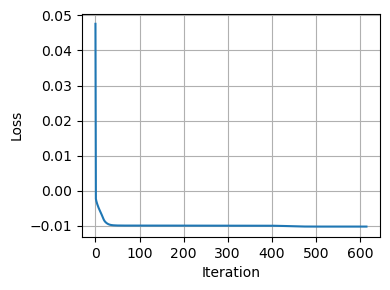

In [36]:
from plot import plot_loss
loss_history = results['loss_history']
plot_loss(loss_history)

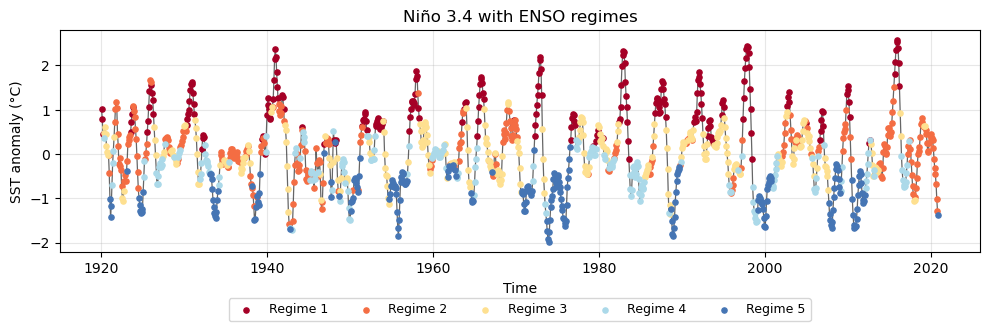

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

def plot_nino34_with_regimes(
    nino34,                   # np.ndarray, shape (Nt,)
    labels,                   # np.ndarray or list, shape (Nt,), ints like 0..K-1 (or -1 for noise)
    time=None,                # None, np.ndarray shape (Nt,), or pandas.DatetimeIndex
    regime_names=None,        # list of names per regime id; len==K
    colors=None,              # list of color strings per regime id; len==K
    rolling=None,             # e.g., 3 or 5 for moving avg window (optional)
    title="Niño 3.4 with clustered regimes"
):
    nino34 = np.asarray(nino34)
    labels = np.asarray(labels)
    assert nino34.shape == labels.shape, "nino34 and labels must have same shape"
    Nt = nino34.size
    if time is None:
        x = np.arange(Nt)
        xlabel = "Time index"
    else:
        x = np.asarray(time)
        xlabel = "Time"
        
    # Handle NaNs: mask both arrays consistently
    good = np.isfinite(nino34) & np.isfinite(labels)
    x_plot = x[good]
    y_plot = nino34[good]
    lab_plot = labels[good].astype(int)

    # Unique regimes (keep order by sorted)
    uniq = np.unique(lab_plot)

    # Build colors
    assert len(colors) >= len(uniq), "Provide enough colors for all regimes"
    palette = colors[:len(uniq)]

    # Map regime id -> color (keep label ids)
    color_map = {lab: palette[i] for i, lab in enumerate(uniq)}

    # Build names
    name_map = {lab: (regime_names[lab] if lab >= 0 else "Noise") for lab in uniq} # If regime ids start at 0..K-1, map directly; for -1 keep "Noise"

    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(x, nino34, 'k', lw=0.9, alpha=0.6)
    for lab in uniq:
        sel = lab_plot == lab
        ax.scatter(x_plot[sel], y_plot[sel], s=14, color=color_map[lab], label=name_map[lab], zorder=3)
    ax.set_ylabel("SST anomaly (°C)")
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    # Deduplicate legend entries (Niño line, rolling mean, regimes)
    handles, labels_ = ax.get_legend_handles_labels()
    seen = {}
    new_h, new_l = [], []
    for h, l in zip(handles, labels_):
        if l not in seen:
            seen[l] = True
            new_h.append(h); new_l.append(l)
    ax.legend(new_h, new_l, ncol=2, fontsize=9)
    # Legend outside bottom
    ax.legend(
        new_h, new_l,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=len(new_l),
        fontsize=9
    )

    plt.tight_layout()
    return fig, ax

colors = [
    "#a50026",  # deep red
    "#f46d43",  # orange-red
    "#fee090",  # light orange
    "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2", "Regime 3", "Regime 4"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm.png')
plt.show()


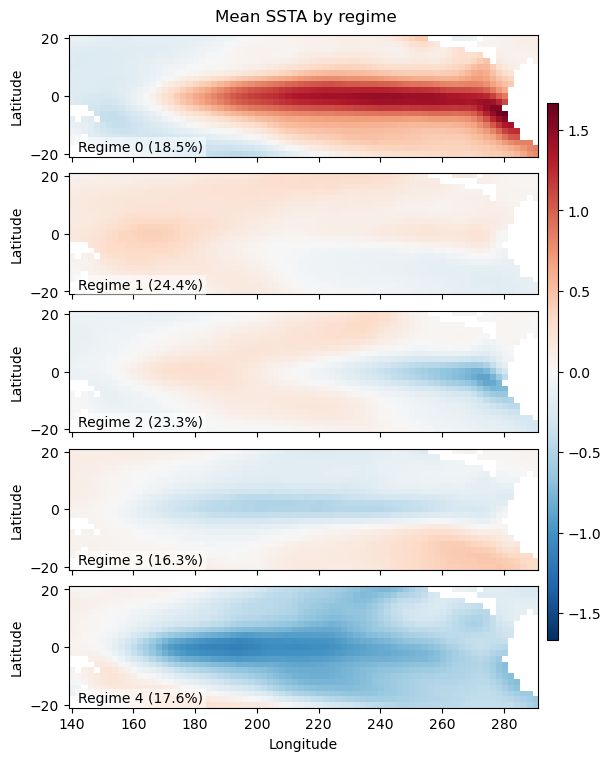

In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

def plot_five_regime_means(mean_maps: xr.DataArray, freq: xr.DataArray, regimes=None, cmap="RdBu_r"):
    """
    Plot five regime-mean anomaly maps with a shared symmetric color scale.
    If 'regimes' is None, the first five regimes in mean_maps.regime are used.
    """
    if regimes is None:
        regimes = mean_maps.regime.values[:5]
    sel = mean_maps.sel(regime=regimes)

    vmax = float(np.nanmax(np.abs(sel.values)))
    vmin = -vmax

    fig, axs = plt.subplots(
        len(regimes), 1, figsize=(6, 1.5*len(regimes)),
        sharex=True, constrained_layout=True
    )

    if len(regimes) == 1:
        axs = [axs]
        
    frq_map = {int(r): float(freq.sel(regime=r).item()) for r in freq.regime.values}

    for ax, reg in zip(axs, regimes):
        patt = sel.sel(regime=reg)
        im = patt.plot.imshow(
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.set_ylabel("Latitude")
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_title("")  # remove any auto-generated title
        r = int(reg)
        frq = frq_map.get(r, 0.0) * 100.0
        ax.text(
            0.02, 0.02, f"Regime {reg} ({frq:.1f}%)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("Mean SSTA by regime", fontsize=12)

mean_maps, freq = mean_anom_per_regime(file["anoms"], new_labels)
plot_five_regime_means(mean_maps, freq, regimes=[0,1,2,3,4])
plt.savefig('../figure/meanssta_regimes_fcm.png')
plt.show()

The regimes are different from Vaittinada Ayar, 2023. One possible reason that FCM based on distance only allows spherical geomotry. In Vaittinada Ayar, 2023, Gaussian mixture clustering is used, which considers intra-cluster correlations. 

# Models: 2D

## Preprocessing

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.nc")
ds.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 79MB
Dimensions:           (time: 1980, bound: 2, latitude: 50, longitude: 200)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 400B -24.5 -23.5 -22.5 ... 23.5 24.5
  * longitude         (longitude) float64 2kB 100.5 101.5 102.5 ... 298.5 299.5
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB ...
    bounds_latitude   (latitude, bound) float64 800B ...
    bounds_longitude  (longitude, bound) float64 3kB ...
    sst               (time, latitude, longitude) float32 79MB ...
    ts_glob           (time) float32 8kB ...
    ts_trop           (time) float32 8kB ...
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribut

In [2]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
# %matplotlib inline

%output holomap='scrubber' fps=3
ds.sel(time=slice("1920-01", "2020-12")).sst.hvplot('longitude', 'latitude', cmap='RdBu_r').redim.range(sst=(-2, 30))

/tmp/ipykernel_2984893/816614438.py:6: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [longitude,latitude]   (sst)

In [3]:
ds.sst

<xarray.DataArray 'sst' (time: 1980, latitude: 50, longitude: 200)> Size: 79MB
[19800000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * latitude   (latitude) float64 400B -24.5 -23.5 -22.5 ... 22.5 23.5 24.5
  * longitude  (longitude) float64 2kB 100.5 101.5 102.5 ... 297.5 298.5 299.5
Attributes:
    original_attribute_comment:        Temperature of the lower boundary of t...
    original_attribute_long_name:      Surface Temperature
    original_attribute_standard_name:  surface_temperature
    original_attribute_units:          K
    original_attribute_variable_name:  ts
    EnsoMetrics_operation:             1) TS (Surface Temperature (skin for o...
    EnsoMetrics_variable_calculation:  ts - 273.15
    EnsoMetrics_standard_name:         sea_surface_temperature
    EnsoMetrics_long_name:             Sea Surface Temperature
    EnsoMetrics_units:                 degC
    EnsoMetrics_variable_name:         sst

In [5]:
ds.sst.time

<xarray.DataArray 'time' (time: 2059)> Size: 16kB
array(['1854-01-01T00:00:00.000000000', '1854-02-01T00:00:00.000000000',
       '1854-03-01T00:00:00.000000000', ..., '2025-05-01T00:00:00.000000000',
       '2025-06-01T00:00:00.000000000', '2025-07-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-07-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 82361.]

Since model data has different spatial grids from the reanalysis data, coarsening and averaging are needed to align the spatial grids.

In [4]:
# Coarsening data
# Ensure longitudes are 0–360 and sorted
if ds.longitude.max() <= 180:
    ds = ds.assign_coords(lon=(ds.lon % 360)).sortby('longitude')
else:
    ds = ds.sortby('longitude')

# 1) Expand the subset by 0.5° so 2x2 blocks will be centered on integers
#    lat bins: [-20.5, -19.5] -> -20, [-18.5, -17.5] -> -18, ..., [19.5, 20.5] -> 20
#    lon bins: [139.5, 140.5] -> 140, ..., [289.5, 290.5] -> 290
ds_block = ds.sel(latitude=slice(-20.5, 20.5), longitude=slice(139.5, 290.5))

# 2) Coarsen to 2°×2° by averaging 2×2 cells
ds_2deg = ds_block.coarsen(latitude=2, longitude=2, boundary='trim').mean()

# 3) Set the coarsened coordinates to the mean-of-blocks (these will be integers)
lat_new = ds_block['latitude'].coarsen(latitude=2, boundary='trim').mean()
lon_new = ds_block['longitude'].coarsen(longitude=2, boundary='trim').mean()
ds_2deg = ds_2deg.assign_coords(latitude=lat_new, longitude=lon_new)

ds_2deg = ds_2deg.sortby('latitude', ascending=False)

In [5]:
ds_2deg

<xarray.Dataset> Size: 13MB
Dimensions:           (time: 1980, bound: 2, latitude: 21, longitude: 76)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 168B 20.0 18.0 16.0 ... -18.0 -20.0
  * longitude         (longitude) float64 608B 140.0 142.0 144.0 ... 288.0 290.0
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB 1850-01-01 ... 2015-0...
    bounds_latitude   (latitude, bound) float64 336B 19.5 20.5 ... -20.5 -19.5
    bounds_longitude  (longitude, bound) float64 1kB 139.5 140.5 ... 289.5 290.5
    sst               (time, latitude, longitude) float32 13MB 24.46 ... nan
    ts_glob           (time) float32 8kB 13.02 13.06 14.05 ... 15.8 14.86 14.29
    ts_trop           (time) float32 8kB 25.12 25.46 25.91 ... 26.57 26.27 25.98
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribute_branch_time_in_child:   0.0
    original_attribute_branch_time_in_parent:  0.0
    original_attribute_calendar:               proleptic_gregorian
    ...                                        ...
    original_attribute_table_info:             Creation Date:(30 April 2019) ...
    original_attribute_title:                  ACCESS-CM2 output prepared for...
    original_attribute_tracking_id:            hdl:21.14100/246cb7d2-3eb7-412...
    original_attribute_variable_id:            ts
    original_attribute_variant_label:          r1i1p1f1
    original_attribute_version:                v20191108

In [6]:
ds_2deg.sel(time=slice("1920-01", "2020-12")).sst.hvplot('longitude', 'latitude', cmap='RdBu_r').redim.range(sst=(-2, 30))

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sst)

## Clustering 

First compute 'pseudo-PCs' by projecting the model data to the EOFs of reanalysis data.

In [42]:
import numpy as np
import xarray as xr

def compute_pcs(data: xr.DataArray,
                eofs: xr.DataArray,
                lat_name: str = "lat",
                lon_name: str = "lon",    
                remove_season=True,
                detrend_linear=True,
                clim_ref=None,
                nino = False,
                pcscaling = 1,
                weight: str = "cos") -> xr.DataArray:
    """
    Compute principal components (PCs) by projecting data onto given EOFs.

    Parameters
    ----------
    data : xr.DataArray
        Anomaly field with dims (..., time, lat, lon) or (time, lat, lon).
    eofs : xr.DataArray
        EOF spatial patterns with dims (mode, lat, lon) or (lat, lon, mode).
        Typically the first 4 modes (mode=1..4).
    lat_name, lon_name : str
        Coordinate names for latitude & longitude.
    weight : {"cos", None}
        If "cos", uses area weights proportional to cos(lat).

    Returns
    -------
    pcs : xr.DataArray
        Time series of PCs with dims (time, mode).
    """
    from scipy.signal import detrend as sp_detrend

    # Auto-rename latitude/longitude if needed
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in data.dims or old in data.coords: rename_map[old] = new
    if rename_map:
        data = data.rename(rename_map)

    # Ensure mode dim is first for EOFs: (mode, lat, lon)
    eofs = eofs.transpose("mode", lat_name, lon_name)

    # Ensure data dims order with time first for convenience: (time, lat, lon, ...)
    data = data.transpose("time", ...)

    # Align on spatial grid
    data, eofs = xr.align(data, eofs, join="inner")

    # ---- Remove seasonal cycle (monthly climatology) ---- 
    if remove_season:
        if clim_ref is None:
            clim = data.groupby("time.month").mean("time")
        elif isinstance(clim_ref, xr.DataArray):
            clim = clim_ref
        else:
            ref = data.sel(time=slice(*clim_ref)) # Select the reference period for climatology
            clim = ref.groupby("time.month").mean("time") # Compute monthly climatology over the reference period
        anoms = data.groupby("time.month") - clim # Subtract monthly climatology from all time steps
    else:
        anoms = data        
        
    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = anoms.sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=(lon_name, lat_name))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
    
    # # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    # Build area weights
    if weight == "cos":
        w_lat = np.sqrt(np.cos(np.deg2rad(anoms[lat_name]))) # Use sqrt of weights for symmetric W^{1/2} usage
        W = (w_lat**2).rename("weight")  # store full weights too if needed
    else:
        W = xr.ones_like(anoms.isel(time=0, drop=True))

    mask = ~(eofs.isnull().any("mode") | anoms.isnull().isel(time=0, drop=True))
    X = anoms.where(mask).stack(space=(lat_name, lon_name))
    E = eofs.where(mask).stack(space=(lat_name, lon_name))
    w = W.where(mask).stack(space=(lat_name, lon_name))
    valid = w.notnull()
    X = X.sel(space=valid); E = E.sel(space=valid); w = w.sel(space=valid)

    Xn, En, wn = X.values, E.values, w.values
    XW = Xn * wn[None, :]
    EW = En * wn[None, :]

    A = EW @ En.T
    B = XW @ En.T
    is_ortho = np.allclose(A, np.eye(A.shape[0]), rtol=1e-6, atol=1e-8)
    PCs = B if is_ortho else (B @ np.linalg.inv(A))

    # Wrap back to xarray
    pcs = xr.DataArray(
        PCs,
        dims=["time", "mode"],
        coords={"time": data["time"], "mode": eofs["mode"]},
        name="PC"
    )

    if pcscaling == 1: # unit-variance PCs (matches eofs pcs(pcscaling=1))
        pcs = pcs / np.sqrt(pcs.var(dim="time", ddof=1))

    out = {
        "PCs": pcs,
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

ds = xr.open_dataset("../data/sst.mnmean.nc")
obs = ds["sst"]
clim_ref_obs = obs.sel(time=slice("1981-01", "2010-12"), lat=slice(20, -20), lon=slice(140, 290)).groupby("time.month").mean("time")
eof_file = xr.open_dataset("../data/ersstv5_eof_nino34_1920_2020.nc")
out = compute_pcs(ds_2deg.sst.sel(time=slice("1920-01", "2014-12")), eof_file.sel(time=slice("1920-01", "2014-12")).EOFs, clim_ref=clim_ref_obs, nino=True)

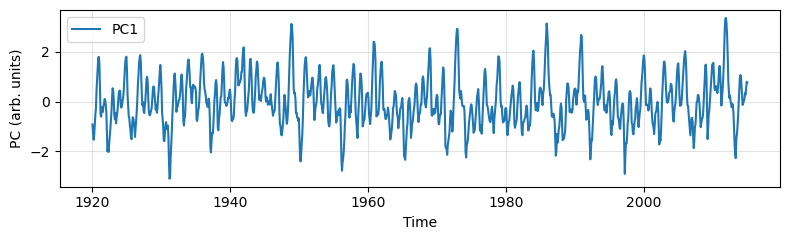

In [32]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(out["time"].values, out["PCs"].sel(mode=1), label=f"PC1")
ax.legend()
ax.grid(True, alpha=0.35)
ax.set_xlabel("Time")
ax.set_ylabel("PC (arb. units)")
plt.tight_layout()
plt.show()
    

In [46]:
ds_out = xr.Dataset(
    data_vars={
        "PCs":    out["PCs"],      # (time, mode)
        "Nino34": out["nino34"],   # (time)
        "anoms":   out["anoms"],    # (time, lat, lon) anomalies used in EOFs
    }
)
ds_out.attrs.update({
    "title": " cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014 Projected PCs and Niño 3.4",
    "climatology_ref": "ERSSTv5: 1981-01 to 2010-12",
    "notes": "EOFs computed based on ERSSTv5, weights = sqrt(cos(lat))",
})

out_path = "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_pcs_nino34_1920_2014.nc"
ds_out.to_netcdf(out_path, format="NETCDF4", mode="w")
print(f"Saved to {out_path}")

Saved to ../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_pcs_nino34_1920_2014.nc


### FCM

Classify the model data into regimes based on pseudo-PCs using the saved clustering model.

In [50]:
file = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_pcs_nino34_1920_2014.nc")
data = file["PCs"].to_numpy()
nino34 = file["Nino34"].to_numpy()

with open('../data/fcm_ersstv5.pkl', 'rb') as f:
    fcm_model_data = pickle.load(f)
cluster_model = FCMEntropy(**fcm_model_data['config'])
cluster_model.centers = fcm_model_data['centers']
cluster_model.weights = fcm_model_data['weights']
scaler = fcm_model_data['scaler']

features = []
features.append(data)
features = np.concatenate(features, axis=1)
features = scaler.transform(features)
weights = cluster_model.predict(features)
labels = np.argmax(weights, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

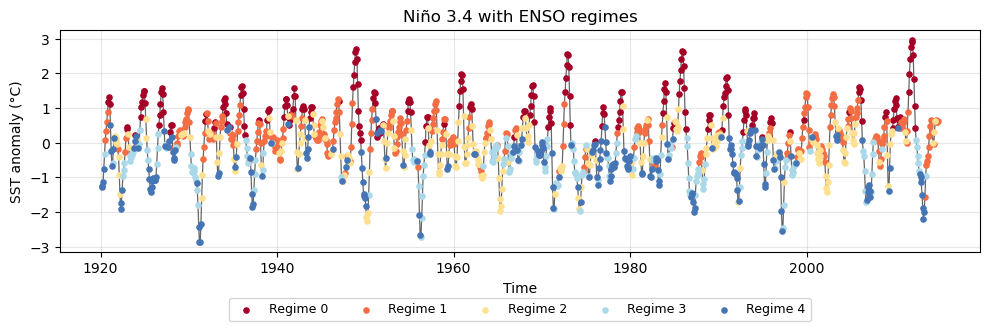

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

colors = [
    "#a50026",  # deep red
    "#f46d43",  # orange-red
    "#fee090",  # light orange
    "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2", "Regime 3", "Regime 4"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.png')
plt.show()

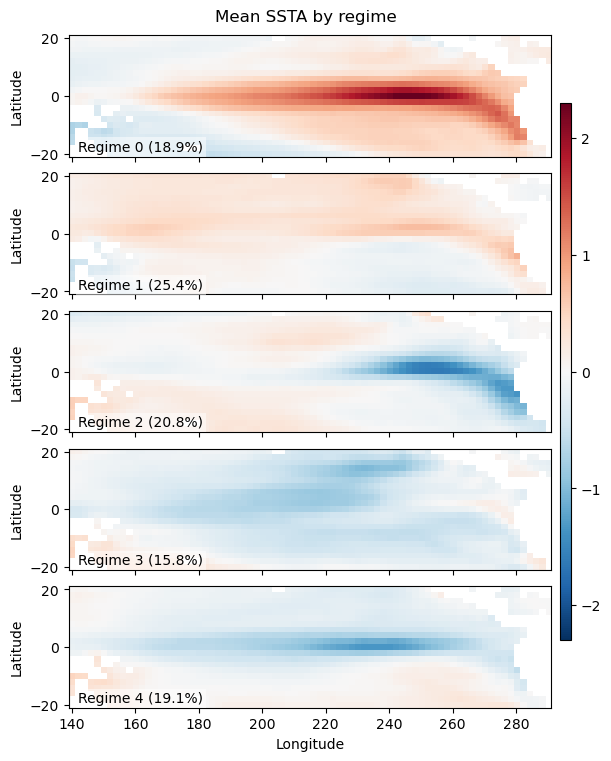

In [54]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

def plot_five_regime_means(mean_maps: xr.DataArray, freq: xr.DataArray, regimes=None, cmap="RdBu_r"):
    """
    Plot five regime-mean anomaly maps with a shared symmetric color scale.
    If 'regimes' is None, the first five regimes in mean_maps.regime are used.
    """
    if regimes is None:
        regimes = mean_maps.regime.values[:5]
    sel = mean_maps.sel(regime=regimes)

    vmax = float(np.nanmax(np.abs(sel.values)))
    vmin = -vmax

    fig, axs = plt.subplots(
        len(regimes), 1, figsize=(6, 1.5*len(regimes)),
        sharex=True, constrained_layout=True
    )

    if len(regimes) == 1:
        axs = [axs]
        
    frq_map = {int(r): float(freq.sel(regime=r).item()) for r in freq.regime.values}

    for ax, reg in zip(axs, regimes):
        patt = sel.sel(regime=reg)
        im = patt.plot.imshow(
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.set_ylabel("Latitude")
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_title("")  # remove any auto-generated title
        r = int(reg)
        frq = frq_map.get(r, 0.0) * 100.0
        ax.text(
            0.02, 0.02, f"Regime {reg} ({frq:.1f}%)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("Mean SSTA by regime", fontsize=12)

mean_maps, freq = mean_anom_per_regime(file["anoms"], new_labels)
plot_five_regime_means(mean_maps, freq, regimes=[0,1,2,3,4])
plt.savefig('../figure/meanssta_regimes_fcm_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.png')
plt.show()

#### PCs check on obs data (projection to EOFs)

In [12]:
pcs_obs = compute_pcs(obs.sel(time=slice("1920-01", "2020-12"), lat=slice(20, -20), lon=slice(140, 290)), eof_file.sel(time=slice("1920-01", "2020-12")).EOFs, clim_ref=clim_ref_obs)  # where eofs_4 has dims (mode, lat, lon)

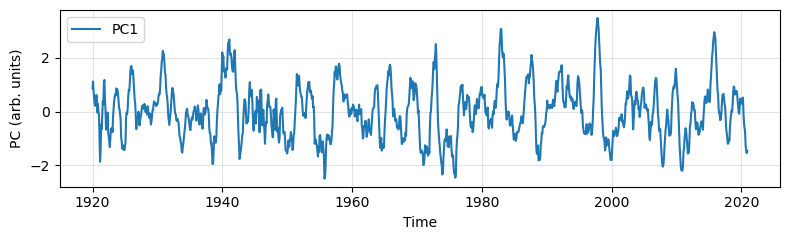

In [13]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(pcs_obs["time"].values, pcs_obs.sel(mode=1), label=f"PC1")
ax.legend()
ax.grid(True, alpha=0.35)
ax.set_xlabel("Time")
ax.set_ylabel("PC (arb. units)")
plt.tight_layout()
plt.show()
    

#### PCA check (be careful about the sign)

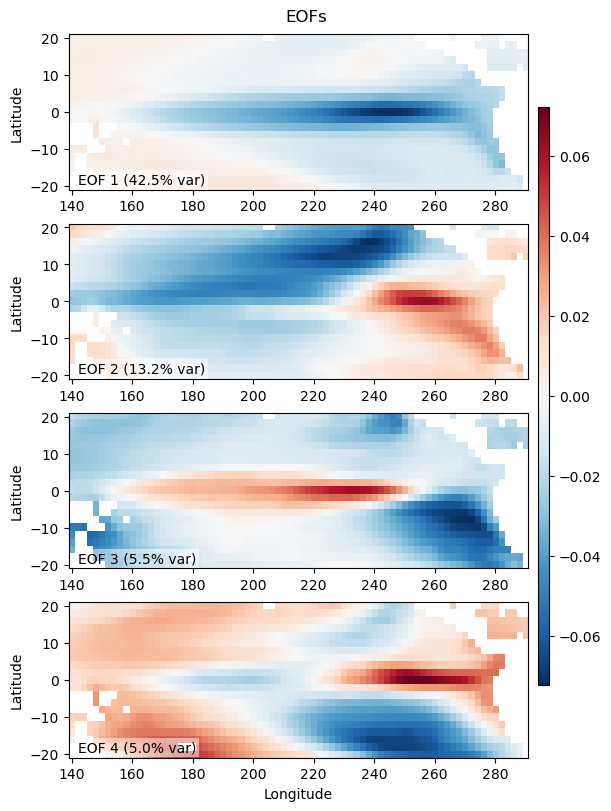

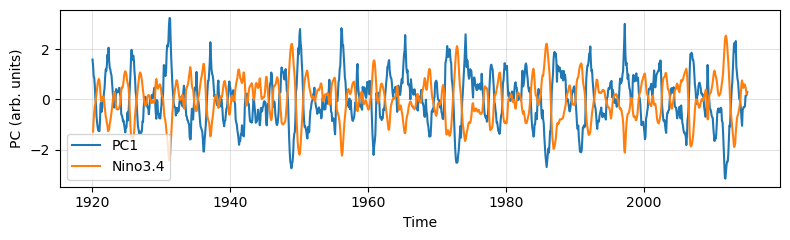

In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
from eofs.xarray import Eof

def pca_ersstv5(
    da,
    time_slice=None,        # e.g. ("1900-01", "2024-12")
    lat_bounds=None,        # e.g. (60, -60)
    lon_bounds=None,        # e.g. (120, 290)   (0..360 in ERSST)
    remove_season=True,
    detrend_linear=True,
    n_modes=10,
    reorder_lat_ascending=False,
    nino=False,
    clim_ref=None,
):
    # Auto-rename latitude/longitude if needed
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in da.dims or old in da.coords: rename_map[old] = new
    if rename_map:
        da = da.rename(rename_map)

    # ---- (Optional) reorder latitude to ascending; safer for weighting/plots ---
    if reorder_lat_ascending and (da.lat.values[0] > da.lat.values[-1]):
        da = da.sortby("lat")

    # ---- Subset time ----
    if time_slice is not None:
        da = da.sel(time=slice(*time_slice))

    # ---- Subset latitude ----
    if lat_bounds is not None:
        lo, hi = lat_bounds
        da = da.sel(lat=slice(lo, hi))

    # ---- Subset longitude ----
    if lon_bounds is not None:
        lo, hi = lon_bounds
        if lo <= hi:
            da = da.sel(lon=slice(lo, hi))
        else:
            # wrap-around case, e.g. (300, 60)
            da = xr.concat(
                [da.sel(lon=slice(lo, 360)), da.sel(lon=slice(0, hi))],
                dim="lon"
            )

    # ---- Remove seasonal cycle (monthly climatology) ----
    if remove_season:
        if clim_ref is None:
            clim = da.groupby("time.month").mean("time")
        elif isinstance(clim_ref, xr.DataArray):
            clim = clim_ref
        else:
            ref = da.sel(time=slice(*clim_ref)) # Select the reference period for climatology
            if ref.time.size == 0:
                raise ValueError(f"clim_ref range {clim_ref} has no overlap with data.")
            clim = ref.groupby("time.month").mean("time") # Compute monthly climatology over the reference period
        anoms = da.groupby("time.month") - clim # Subtract monthly climatology from all time steps
    else:
        anoms = da        

    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = anoms.sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=('lon', 'lat'))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
    
    # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    lat_rad = np.deg2rad(anoms["lat"])
    w_lat = np.sqrt(np.cos(lat_rad))
    w2d = w_lat.broadcast_like(anoms.isel(time=0)) # Expand to 2D (lat, lon) for clean broadcasting
    
    # anoms_w = anoms * w2d
    # anoms_w = anoms_w[:, np.isfinite(anoms_w).all("time")]
    # anoms_w.mean(dim=['lon', 'lat']).plot(label='detrended')
    # plt.grid()
    # plt.legend()

    solver = Eof(anoms.transpose("time", "lat", "lon"), weights=w2d)
    EOFs = solver.eofs(neofs=n_modes)
    PCs = solver.pcs(npcs=n_modes, pcscaling=1)
    evrs = solver.varianceFraction()
    EOFs = EOFs.assign_coords(mode=np.arange(1, EOFs.sizes["mode"]+1))

    out = {
        "EOFs": EOFs,  # [mode, lat, lon] in °C units
        "PCs": xr.DataArray(PCs, coords={"time": anoms["time"], "mode": np.arange(1, n_modes+1)}, dims=["time","mode"]),
        "evrs": xr.DataArray(evrs[:n_modes], coords={"mode": np.arange(1, n_modes+1)}, dims=["mode"]),
        # "singular_values": s[:k],
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

def plot_eofs(eofs, evr, modes=(1,2,3), vmin=None, vmax=None):
    modes = list(modes)
    fig, axs = plt.subplots(len(modes), 1, figsize=(6, 2*len(modes)), constrained_layout=True)
    if len(modes) == 1: axs = [axs]
    for ax, m in zip(axs, modes):
        patt = eofs.sel(mode=m)
        patt = patt.sortby("lat")
        im = patt.plot.imshow(
            ax=ax, cmap="RdBu_r", vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        ax.set_title("")
        ax.text(
            0.02, 0.02, f"EOF {m} ({evr.sel(mode=m).item()*100:.1f}% var)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("EOFs", fontsize=12)
    
def plot_pcs(pcs, modes=(1,2,3), nino=None):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    for m in modes:
        ax.plot(pcs["time"].values, pcs.sel(mode=m), label=f"PC{m}")
    if nino is not None:
        ax.plot(nino["time"].values, nino, label=f"Nino3.4")
    ax.legend()
    ax.grid(True, alpha=0.35)
    ax.set_xlabel("Time")
    ax.set_ylabel("PC (arb. units)")
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    res = pca_ersstv5(
        ds_2deg.sst.sel(time=slice("1920-01", "2014-12")),
        time_slice=("1920-01", "2014-12"),
        lat_bounds=(20, -20),
        lon_bounds=(140, 290),
        remove_season=True,
        detrend_linear=True,
        n_modes=4,
        nino=True,
        clim_ref=("1981-01", "2010-12"),
    )

    plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
    # plt.savefig('../figure/eofs.png')
    plot_pcs(res["PCs"], modes=(1,), nino=res['nino34'])

In [38]:
modes_flip = [0,2,3]
for mode in modes_flip:
    res["EOFs"][mode] = -res["EOFs"][mode]
    res["PCs"][:, mode] = -res["PCs"][:, mode]

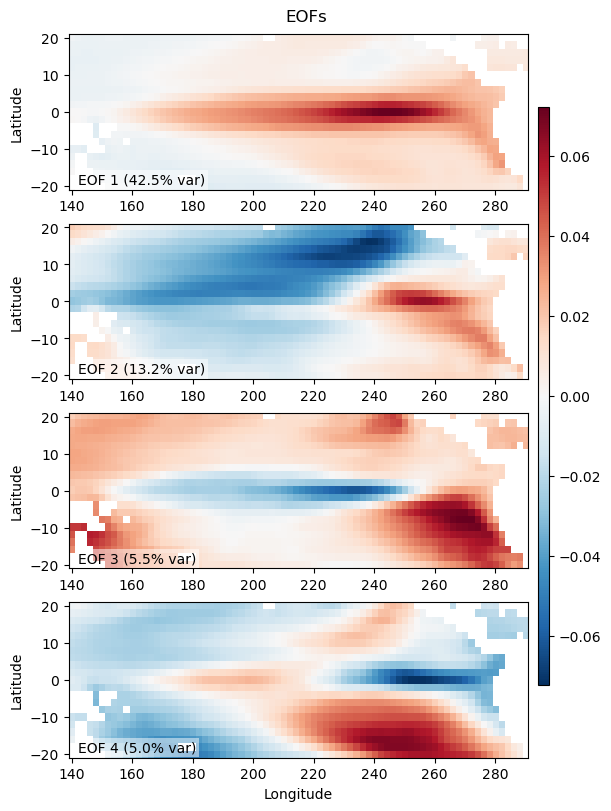

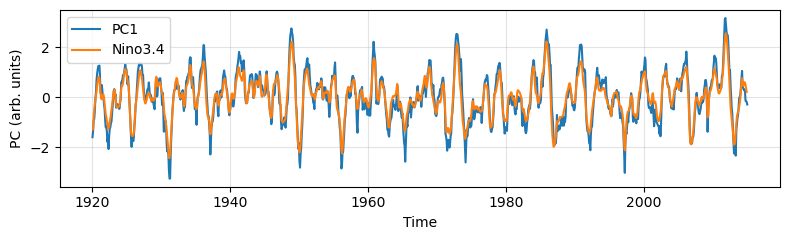

In [39]:
plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
# plt.savefig('../figure/eofs.png')
plot_pcs(res["PCs"], modes=(1,), nino=res['nino34'])

## Modeling

# Observation: 1D

In [1]:
import xarray as xr
ds = xr.open_dataset('../data/sst.mnmean.nc')

import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
%output holomap='scrubber' fps=3
ds.sst.hvplot('lon', 'lat', cmap='RdBu_r').redim.range(ssh=(-4, 4))

/tmp/ipykernel_2595369/4035173717.py:7: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [lon,lat]   (Monthly Means of Sea Surface Temperature)

In [1]:
import xarray as xr
ds = xr.open_dataset('../data/sst.mnmean.nc')
ds

<xarray.Dataset> Size: 132MB
Dimensions:    (lat: 89, lon: 180, time: 2059, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 33kB ...
    sst        (time, lat, lon) float32 132MB ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2025-08-03

## Anomalies

#### Check Detrend polynomial degree

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ENSO import Polynomial_Detrend
'''
equatorial mean(1d) -> detrend(1d) -> remove seasonal(1d, only for nino)
instead of 
remove seasonal(2d) -> detrend(2d) -> equatorial mean(1d)
'''
ds = xr.open_dataset('../data/sst.mnmean.nc')
sst_eq = ds['sst'].sel(time=slice("1920-01", "2025-07"),
                       lon=slice(120, 280),
                       lat=slice(5, -5))

# weighted mean = weighted sum / sum of weights over the same valid mask
w_lat = np.cos(np.deg2rad(sst_eq["lat"])) # Area weights (cos(lat))
w2d = w_lat.broadcast_like(sst_eq.isel(time=0))  # (lat, lon)
num = (sst_eq * w2d).sum(dim="lat", skipna=True)
den = w2d.where(sst_eq.notnull()).sum(dim="lat", skipna=True)
sst_eq_1d = num / den  # (time × lon)


In [2]:
sst_eq_1d

<xarray.DataArray (time: 1267, lon: 81)> Size: 411kB
array([[27.807714, 27.940075, 27.9618  , ..., 24.685865, 24.798388,
        25.319826],
       [28.122572, 28.199448, 28.153643, ..., 25.511898, 24.900047,
        24.673544],
       [28.269436, 28.382914, 28.372242, ..., 25.878399, 25.007095,
        24.633585],
       ...,
       [29.964195, 29.982855, 29.965136, ..., 25.383669, 25.338478,
        26.481993],
       [29.650425, 29.61408 , 29.521622, ..., 24.876308, 24.891489,
        26.130798],
       [29.329565, 29.284615, 29.147463, ..., 24.4233  , 24.480938,
        25.77413 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 324B 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
  * time     (time) datetime64[ns] 10kB 1920-01-01 1920-02-01 ... 2025-07-01

In [3]:
detrend_model = Polynomial_Detrend(degree=5)
detrend_model.fit(sst_eq_1d)

In [4]:
t_points = np.arange(1267)
trend = detrend_model.predict(t_points)

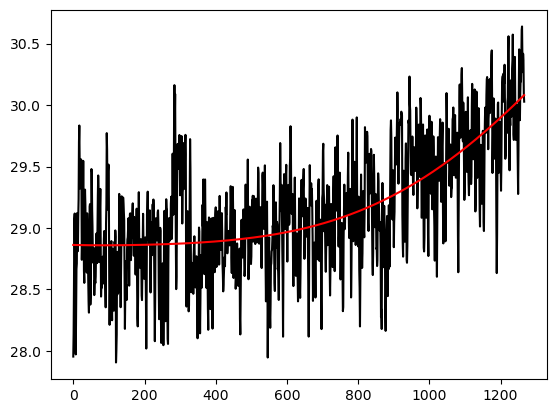

In [5]:
ix = 10
plt.plot(sst_eq_1d[:, ix], 'k')
plt.plot(trend[:, ix], 'r')

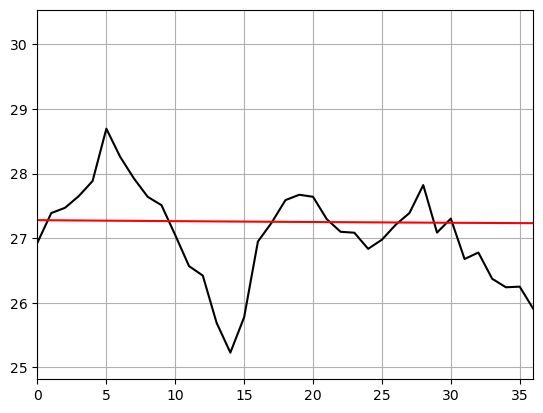

In [8]:
ix = 40
plt.plot(sst_eq_1d[:, ix], 'k')
plt.plot(trend[:, ix], 'r')
plt.xlim(0,36)
plt.grid()

### SST

(1267, 81)


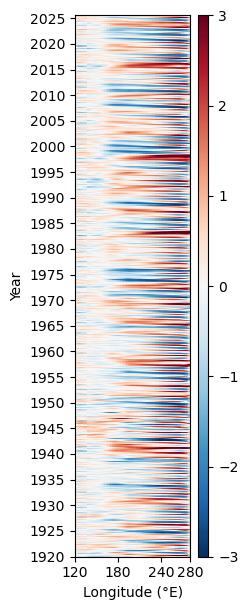

In [40]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ENSO import Polynomial_Detrend
'''
equatorial mean(1d) -> detrend(1d) -> remove seasonal(1d, only for nino)
instead of 
remove seasonal(2d) -> detrend(2d) -> equatorial mean(1d)
'''
ds = xr.open_dataset('../data/sst.mnmean.nc')
sst_eq = ds['sst'].sel(time=slice("1920-01", "2025-07"),
                       lon=slice(120, 280),
                       lat=slice(5, -5))

# weighted mean = weighted sum / sum of weights over the same valid mask
w_lat = np.cos(np.deg2rad(sst_eq["lat"])) # Area weights (cos(lat))
w2d = w_lat.broadcast_like(sst_eq.isel(time=0))  # (lat, lon)
num = (sst_eq * w2d).sum(dim="lat", skipna=True)
den = w2d.where(sst_eq.notnull()).sum(dim="lat", skipna=True)
sst_eq_1d = num / den  # (time × lon)

print(sst_eq_1d.shape)

# Fit and save the detrend model
detrend_model = Polynomial_Detrend(degree=5)
detrend_model.fit(sst_eq_1d)
detrend_model.save("../model/detrend_obs_1d.npz")

# Linear detrend per grid cell (along time)
def _poly_detrend_1d(x, degree=5):
    if np.all(np.isnan(x)):
        return x
    model = Polynomial_Detrend(degree=degree)
    model.fit(x[:, np.newaxis])
    t_points = np.arange(len(x))
    trend = model.predict(t_points).ravel()
    return x - trend
sst_eq_1d = xr.apply_ufunc(
    _poly_detrend_1d, sst_eq_1d,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[sst_eq_1d.dtype]
)

# Remove seasonal cycle (monthly climatology over a reference period) and calculate Nino index
clim_ref = ("1981-01", "2010-12")
ref = sst_eq_1d.sel(time=slice(*clim_ref))
clim = ref.groupby("time.month").mean("time", skipna=True)
anoms_eq_1d = sst_eq_1d.groupby("time.month") - clim
nino34 = anoms_eq_1d.sel(lon=slice(190, 240)).mean(dim=('lon')).rolling(time=3, center=True).mean()

# Hovmöller plot
fig, ax = plt.subplots(figsize=(2.5, 6.2))  # wider than tall usually looks better
sst_eq_1d = sst_eq_1d.transpose("time", "lon") # Ensure C has shape (Nt, Nx) = (len(time), len(lon))
pcm = ax.pcolormesh(
    sst_eq_1d["lon"].values,                # X (Nx)
    pd.to_datetime(sst_eq_1d["time"].values), # Y (Ny)
    sst_eq_1d.values,                                # C (Ny, Nx)
    cmap="RdBu_r",
    shading="auto",
    vmin=-3, vmax=3
)
cb = plt.colorbar(pcm, ax=ax, aspect=50)
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Year")
ax.yaxis.set_major_locator(mdates.YearLocator(5))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xticks([120, 180, 240, 280])
ax.set_xlim(120, 280)
plt.tight_layout()
plt.savefig('../figure/hovmoller_sst_obs.png', dpi=150)
plt.show()

In [41]:
ds_out = xr.Dataset(
    data_vars={
        "eq_ssta": sst_eq_1d,  # (lon, time)
        "nino34": nino34,          # (time)
    }
)
ds_out.attrs.update({
    "title": "ERSSTv5 Equatorial SSTA and Niño 3.4",
    "climatology_ref": "1981-01 to 2010-12",
    "notes": "SSTA are weighted by cos(lat)",
})

out_path = "../data/ssta_nino34_obs_1d.nc"
ds_out.to_netcdf(out_path, format="NETCDF4", mode="w")
print(f"Saved to {out_path}")

Saved to ../data/ssta_nino34_obs_1d.nc


##### Check the decorrelation time

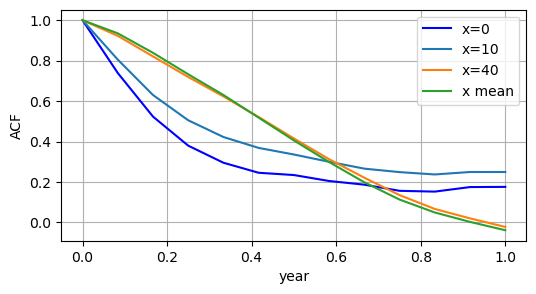

Decorrelation Time: 0.3213528926902827
Decorrelation Time: 0.41520624975343806
Decorrelation Time: 0.43892770618143573
Decorrelation Time: 0.43369687077519403


In [17]:
import numpy as np
import xarray as xr
from statsmodels.tsa.stattools import acf, ccf
from scipy.integrate import simpson
import matplotlib.pyplot as plt

file = xr.open_dataset("../data/ssta_nino34_ersstv5_1d.nc")
data = file["eq_ssta"].to_numpy()

Lag = 12
dt_ob = 1/12
acf0 = acf(data[:, 0], nlags=Lag)
acf1 = acf(data[:, 10], nlags=Lag)
acf2 = acf(data[:, 40], nlags=Lag)
acf3 = acf(np.mean(data, axis=1), nlags=Lag)
tt = np.linspace(0, Lag*dt_ob, num=Lag+1, endpoint=True)
plt.figure(figsize=(6, 3))
plt.plot(tt, acf0, color='b', label='x=0')
plt.plot(tt, acf1, label='x=10')
plt.plot(tt, acf2, label='x=40')
plt.plot(tt, acf3, label='x mean')
plt.ylabel('ACF')
plt.xlabel('year')
plt.legend()
plt.grid()
plt.show()

decorr_time = simpson(acf0, dx=dt_ob)
print(f'Decorrelation Time: {decorr_time}')
decorr_time = simpson(acf1, dx=dt_ob)
print(f'Decorrelation Time: {decorr_time}')
decorr_time = simpson(acf2, dx=dt_ob)
print(f'Decorrelation Time: {decorr_time}')
decorr_time = simpson(acf3, dx=dt_ob)
print(f'Decorrelation Time: {decorr_time}')

### SSH

In [27]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ENSO import Polynomial_Detrend
'''
equatorial mean(1d) -> remove seasonal(1d) -> detrend(1d)
instead of 
remove seasonal(2d) -> detrend(2d) -> equatorial mean(1d)
'''
ds = xr.open_dataset('../data/SSH_interpolated_2deg_1981_2025.nc')

In [28]:
ds

<xarray.Dataset> Size: 25MB
Dimensions:        (lat: 65, lon: 180, time: 535, strlen: 10)
Coordinates:
  * lat            (lat) float64 520B 64.0 62.0 60.0 58.0 ... -60.0 -62.0 -64.0
  * lon            (lon) float64 1kB 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time           (time) datetime64[ns] 4kB 1981-01-01 ... 2025-07-01
Dimensions without coordinates: strlen
Data variables:
    ssh            (time, lat, lon) float32 25MB ...
    time_datetime  (strlen, time) |S1 5kB ...
Attributes:
    title:    Merged monthly SSH interpolated to 2-degree grid

In [29]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
# %matplotlib inline

%output holomap='scrubber' fps=3
ds.ssh.hvplot('lon', 'lat', cmap='RdBu_r').redim.range(ssh=(-4, 4))

/tmp/ipykernel_1482535/333810163.py:6: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [lon,lat]   (ssh)

### Combine obs data for DA tests

In [48]:
def weighted_mean(data):
    # weighted mean using area weights (cos(lat))
    w_lat = np.cos(np.deg2rad(data["lat"])) 
    w2d = w_lat.broadcast_like(data.isel(time=0))  # (lat, lon)
    num = (data * w2d).sum(dim="lat", skipna=True)
    den = w2d.where(data.notnull()).sum(dim="lat", skipna=True)
    mean = num / den  # (time × lon)
    return mean
    
file_paths= [
    "../data/sst.mnmean.nc", 
    "SSH_interpolated_2deg_1981_2025.nc",
            ]
out_path = "../data/obs_sst_ssh_1d.nc"
var_names=["sst", "ssh"]
data_dic = {}
for path, name in zip(file_paths, var_names):
    with xr.open_dataset(path) as ds_raw:
        ds_raw[name] = ds_raw[name].where(np.abs(ds_raw[name]) < 1e30) # convert Inf to NaN
        ds_proc = weighted_mean(ds_raw[name].sel(time=slice("2005-07", "2025-07"), lon=slice(120, 280), lat=slice(5, -5)))
    data_dic[name] = ds_proc
ds_out = xr.Dataset(data_dic)
ds_out.to_netcdf(out_path, format="NETCDF4", mode="w")
ds_out.attrs.update({
"title": "Equatorial mean of obs data (120E, 280E), (5N, -5N)",
"variables": "SST, SSH",
"time range": "2005-07 - 2025-07"
})
print(f"Saved to {out_path}")

Saved to ../data/obs_sst_ssh_1d.nc


In [49]:
ds = xr.open_dataset('../data/obs_sst_ssh_1d.nc')
ds

<xarray.Dataset> Size: 237kB
Dimensions:  (lon: 81, time: 241)
Coordinates:
  * lon      (lon) float32 324B 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
  * time     (time) datetime64[ns] 2kB 2005-07-01 2005-08-01 ... 2025-07-01
Data variables:
    sst      (time, lon) float32 78kB ...
    ssh      (time, lon) float64 156kB ...

In [50]:
ds = xr.open_dataset('../data/obs_sst_ssh_1d.nc')
arrays = [ds[v] for v in ds.data_vars] # shape: (var, time, lon)
data = xr.concat(arrays, dim='var').transpose('time', 'var', 'lon').values
data.shape

(241, 2, 81)

In [51]:
data[0, 1, :]

array([0.62765246, 0.61228399, 0.58934463, 0.58241821, 0.56223917,
       0.56445345, 0.57767507, 0.59550411, 0.59227762, 0.5885441 ,
       0.58930465, 0.5820123 , 0.57773021, 0.58882232, 0.58569712,
       0.58860074, 0.59296799, 0.59965051, 0.60725653, 0.61201658,
       0.61375579, 0.61382845, 0.61184106, 0.60770963, 0.60049157,
       0.58961156, 0.57842204, 0.56754507, 0.55533962, 0.54142207,
       0.52716639, 0.51414702, 0.50322397, 0.4951107 , 0.48837932,
       0.48114632, 0.47190924, 0.45966059, 0.44639553, 0.43469584,
       0.42527515, 0.41772156, 0.41032286, 0.39903381, 0.38564989,
       0.37434281, 0.36618298, 0.3583705 , 0.35053053, 0.34221423,
       0.3306775 , 0.31549784, 0.30117888, 0.28973203, 0.28076558,
       0.27536954, 0.269114  , 0.26258514, 0.2557003 , 0.25018897,
       0.24463081, 0.23625283, 0.22860697, 0.2235766 , 0.22062513,
       0.21663313, 0.2125613 , 0.21012925, 0.20513319, 0.19880776,
       0.19657654, 0.19757491, 0.19771968, 0.19670196, 0.19336

## Clustering

### FCM

In [65]:
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy
from time import time
import pickle

def reorder_labels_by_mean_nino34(nino34, labels):
    """
    Reorder integer labels so that the highest-mean Niño 3.4
    regime is label 0, next highest is label 1, etc.
    """
    labels = np.asarray(labels)
    nino34 = np.asarray(nino34)

    unique_labels = np.unique(labels)
    means = {lab: np.nanmean(nino34[labels == lab]) for lab in unique_labels}

    # Sort regime IDs by descending mean Niño 3.4
    sorted_labs = sorted(unique_labels, key=lambda x: means[x], reverse=True)

    # Map old label -> new label (0, 1, 2, ...)
    remap = {old: new for new, old in enumerate(sorted_labs)}
    new_labels = np.array([remap[lab] for lab in labels])

    return new_labels, remap, means
    
np.random.seed(0)

########################## load data ############################
file = xr.open_dataset("../data/ssta_nino34_ersstv5_1d.nc")
data = file["eq_ssta"].to_numpy()
nino34 = file["nino34"].to_numpy()
train_size = 1212 # training data size
test_size = 0 # test data size

######################### clustering ############################
K = 2 # number of clusters (regimes)
L = 1 # time delay steps
data = data[:train_size]
Nt, _ = data.shape # currently only SSTA
features = []
features.append(np.mean(np.stack([data[i:Nt+i-L+1] for i in range(L)], axis=2), axis=2)) # (SSTA window mean)
# features.append(np.mean(np.stack([np.abs(data[i:Nt-L+i+1]-data[i-1:Nt-L+i]) for i in range(1,L)], axis=2), axis=2)) # (|SSTA difference|)
# optional: CP, EP: nino4, nino3
# optional: SSH (unobserved)
data_embedded = np.concatenate(features, axis=1)

# standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_embedded)

# clustering
cluster_model = FCMEntropy(num_clusters=K, m=1.8, lambda_e=.2, num_steps=1000, seed=0)
results = cluster_model.fit(data_scaled, optimizer='iterative')
membership = results['membership']
centers = results['centers']
labels = np.argmax(membership, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34[L-1:], labels)

# save the clustering model
fcm_model_data = {
    'centers': cluster_model.centers,
    'weights': cluster_model.weights,
    'scaler': scaler,
    'config': {
        'num_clusters': cluster_model.num_clusters,
        'm': cluster_model.m,
        'lambda_e': cluster_model.lambda_e,
    }}
with open('../data/fcm_ersstv5_1d.pkl', 'wb') as f:
    pickle.dump(fcm_model_data, f)

In [66]:
data_embedded.shape

(1212, 81)

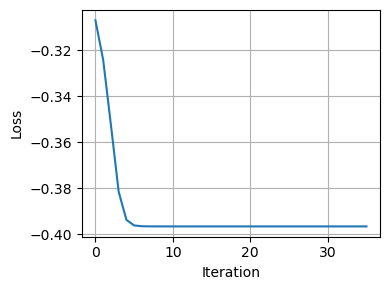

In [67]:
from plot import plot_loss
loss_history = results['loss_history']
plot_loss(loss_history)

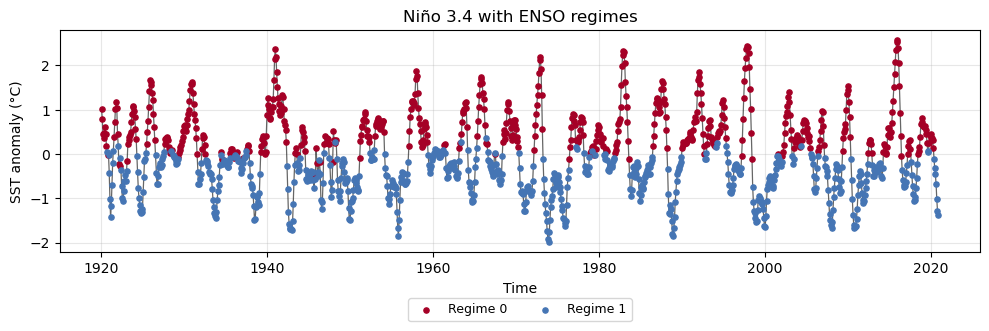

In [68]:
'''
features: window mean only
'''
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_nino34_with_regimes

colors = [
    "#a50026",  # deep red
    # "#f46d43",  # orange-red
    # "#fee090",  # light orange
    # "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34[L-1:], new_labels, time=file["time"][L-1:],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm_1d.png')
plt.show()

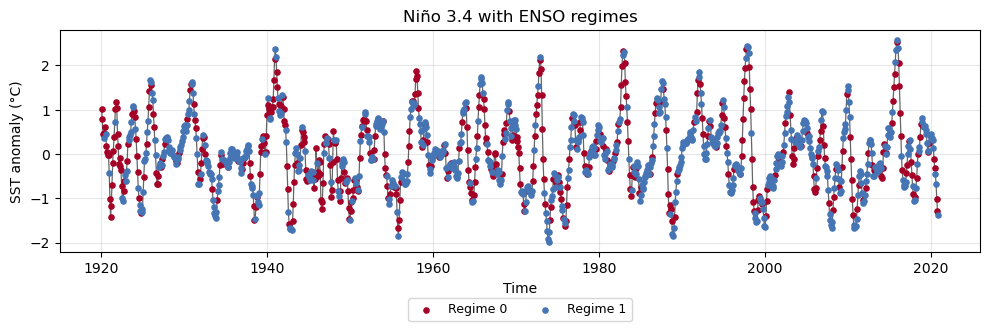

In [38]:
'''
features: difference only
'''
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_nino34_with_regimes

colors = [
    "#a50026",  # deep red
    # "#f46d43",  # orange-red
    # "#fee090",  # light orange
    # "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34[L-1:], new_labels, time=file["time"][L-1:],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
# plt.savefig('../figure/nino34_regimes_fcm_1d.png')
plt.show()

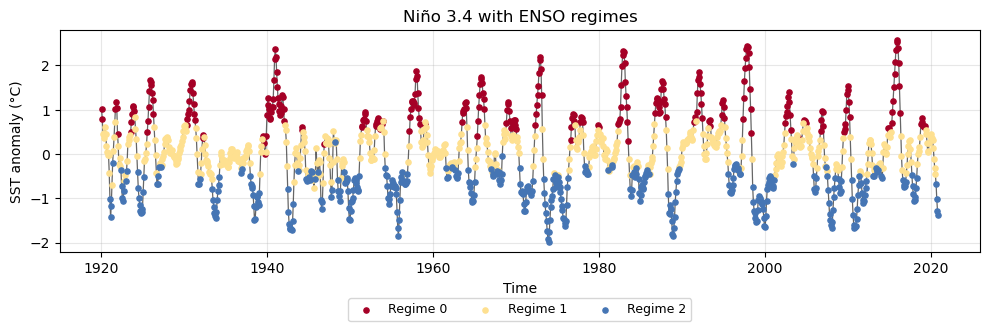

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_nino34_with_regimes

colors = [
    "#a50026",  # deep red
    # "#f46d43",  # orange-red
    "#fee090",  # light orange
    # "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
# plt.savefig('../figure/nino34_regimes_fcm_1d.png')
plt.show()

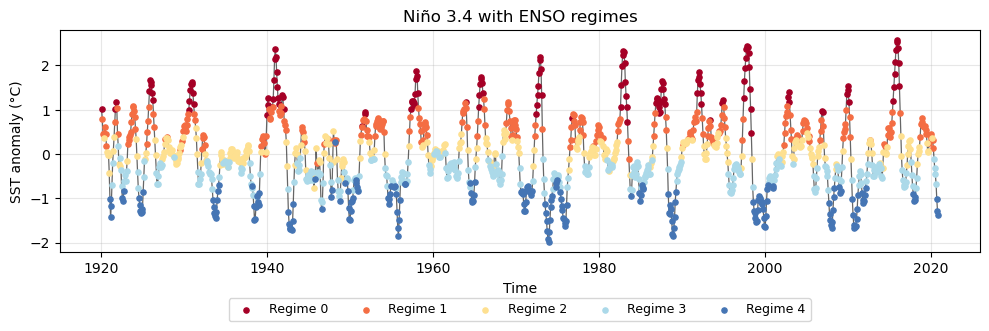

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_nino34_with_regimes

colors = [
    "#a50026",  # deep red
    "#f46d43",  # orange-red
    "#fee090",  # light orange
    "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2", "Regime 3", "Regime 4"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
# plt.savefig('../figure/nino34_regimes_fcm_1d.png')
plt.show()

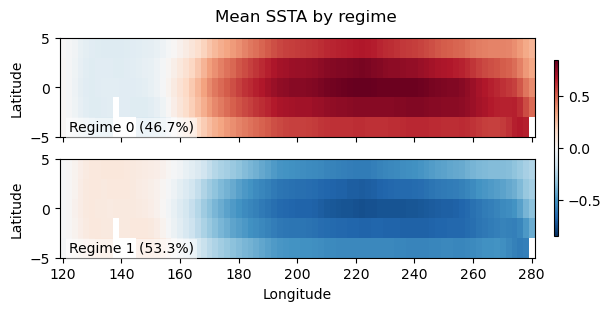

In [69]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

from plot import plot_regime_means
mean_maps, freq = mean_anom_per_regime(file["ssta"], new_labels)
plot_regime_means(mean_maps, freq, regimes=[0,1])
plt.savefig('../figure/meanssta_regimes_fcm_1d.png')
plt.show()

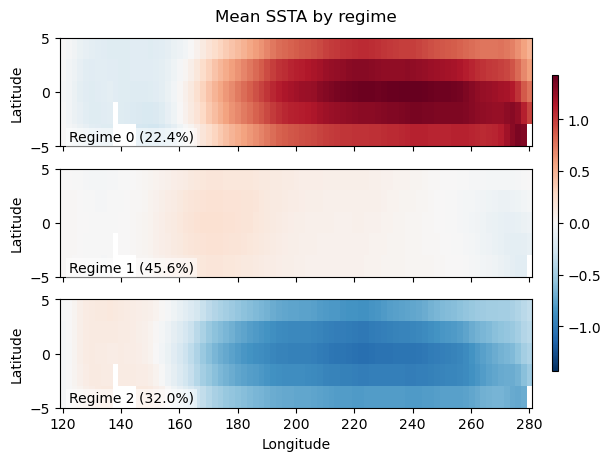

In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

from plot import plot_regime_means
mean_maps, freq = mean_anom_per_regime(file["ssta"], new_labels)
plot_regime_means(mean_maps, freq, regimes=[0,1,2])
plt.savefig('../figure/meanssta_regimes_fcm_1d.png')
plt.show()

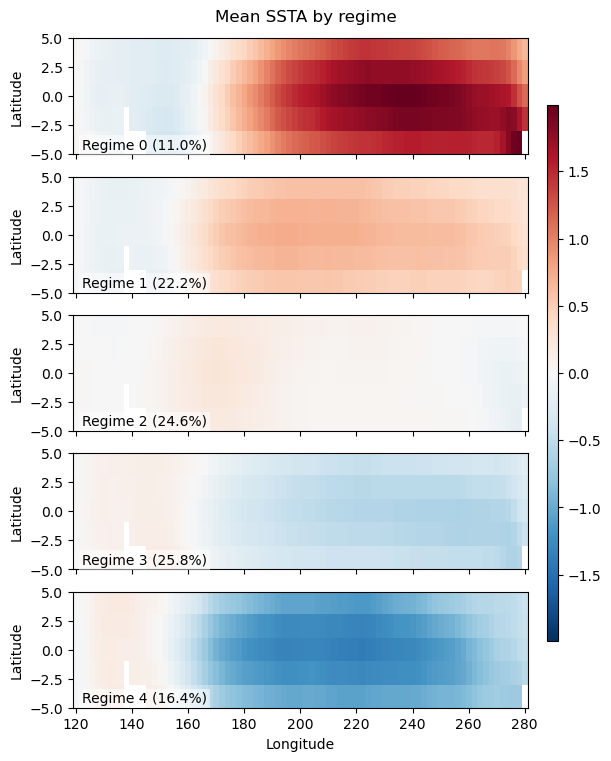

In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

from plot import plot_regime_means
mean_maps, freq = mean_anom_per_regime(file["ssta"], new_labels)
plot_regime_means(mean_maps, freq, regimes=[0,1,2,3,4])
# plt.savefig('../figure/meanssta_regimes_fcm_1d.png')
plt.show()

# Models: 1D

## Preprocessing

#### Since model data has different spatial grids from the reanalysis data, coarsening and averaging are needed to align the spatial grids.

In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.nc")
ds.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 79MB
Dimensions:           (time: 1980, bound: 2, latitude: 50, longitude: 200)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 400B -24.5 -23.5 -22.5 ... 23.5 24.5
  * longitude         (longitude) float64 2kB 100.5 101.5 102.5 ... 298.5 299.5
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB ...
    bounds_latitude   (latitude, bound) float64 800B ...
    bounds_longitude  (longitude, bound) float64 3kB ...
    sst               (time, latitude, longitude) float32 79MB ...
    ts_glob           (time) float32 8kB ...
    ts_trop           (time) float32 8kB ...
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribut

In [44]:
# Coarsening data
# Ensure longitudes are 0–360 and sorted
if ds.longitude.max() <= 180:
    ds = ds.assign_coords(lon=(ds.lon % 360)).sortby('longitude')
else:
    ds = ds.sortby('longitude')

# 1) Expand the subset by 0.5° so 2x2 blocks will be centered on integers
#    lat bins: [-20.5, -19.5] -> -20, [-18.5, -17.5] -> -18, ..., [19.5, 20.5] -> 20
#    lon bins: [139.5, 140.5] -> 140, ..., [289.5, 290.5] -> 290
ds_block = ds.sel(latitude=slice(-20.5, 20.5), longitude=slice(119.5, 290.5))

# 2) Coarsen to 2°×2° by averaging 2×2 cells
ds_2deg = ds_block.coarsen(latitude=2, longitude=2, boundary='trim').mean()

# 3) Set the coarsened coordinates to the mean-of-blocks (these will be integers)
lat_new = ds_block['latitude'].coarsen(latitude=2, boundary='trim').mean()
lon_new = ds_block['longitude'].coarsen(longitude=2, boundary='trim').mean()
ds_2deg = ds_2deg.assign_coords(latitude=lat_new, longitude=lon_new)

ds_2deg = ds_2deg.sortby('latitude', ascending=False)

def rename_lat_lon(data):
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in data.dims or old in data.coords: rename_map[old] = new
    return data.rename(rename_map)
ds_2deg = rename_lat_lon(ds_2deg)

In [11]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
# %matplotlib inline

%output holomap='scrubber' fps=3
ds.sel(time=slice("1920-01", "2020-12")).sst.hvplot('longitude', 'latitude', cmap='RdBu_r').redim.range(sst=(-2, 30))

/tmp/ipykernel_4017885/816614438.py:6: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [longitude,latitude]   (sst)

In [12]:
ds.sst

<xarray.DataArray 'sst' (time: 1980, latitude: 50, longitude: 200)> Size: 79MB
[19800000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * latitude   (latitude) float64 400B -24.5 -23.5 -22.5 ... 22.5 23.5 24.5
  * longitude  (longitude) float64 2kB 100.5 101.5 102.5 ... 297.5 298.5 299.5
Attributes:
    original_attribute_comment:        Temperature of the lower boundary of t...
    original_attribute_long_name:      Surface Temperature
    original_attribute_standard_name:  surface_temperature
    original_attribute_units:          K
    original_attribute_variable_name:  ts
    EnsoMetrics_operation:             1) TS (Surface Temperature (skin for o...
    EnsoMetrics_variable_calculation:  ts - 273.15
    EnsoMetrics_standard_name:         sea_surface_temperature
    EnsoMetrics_long_name:             Sea Surface Temperature
    EnsoMetrics_units:                 degC
    EnsoMetrics_variable_name:         sst

In [13]:
ds.sst.time

<xarray.DataArray 'time' (time: 1980)> Size: 16kB
array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ..., '2014-10-16T12:00:00.000000000',
       '2014-11-16T00:00:00.000000000', '2014-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...
Attributes:
    bounds:        time_bnds
    axis:          T
    realtopology:  linear

#### Preprocess all variables and combine them in a single file.

In [37]:
import os
from pathlib import Path
import numpy as np
import xarray as xr

def weighted_mean(data):
    # weighted mean using area weights (cos(lat))
    w_lat = np.cos(np.deg2rad(data["lat"])) 
    w2d = w_lat.broadcast_like(data.isel(time=0))  # (lat, lon)
    num = (data * w2d).sum(dim="lat", skipna=True)
    den = w2d.where(data.notnull()).sum(dim="lat", skipna=True)
    mean = num / den  # (time × lon)
    return mean
    
def preprocess(ds: xr.Dataset, name) -> xr.Dataset:
    # Standardize coordinates names
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in ds.dims or old in ds.coords: rename_map[old] = new
    ds = ds.rename(rename_map)

    # Ensure longitudes are 0–360
    if ds.lon.max() <= 180:
        ds = ds.assign_coords(lon=(ds.lon % 360))
    # Ensure longitudes and latitudes are ordered
    ds = ds.sortby('lon', ascending=True)
    ds = ds.sortby('lat', ascending=False)

    # Coarsening data to 2°×2° by averaging 2×2 cells (lat bins: [-20.5, -19.5] -> -20, lon bins: [139.5, 140.5] -> 140)
    ds_block = ds[name].sel(lat=slice(20.5, -20.5), lon=slice(119.5, 290.5))
    ds_2deg = ds_block.coarsen(lat=2, lon=2, boundary='trim').mean()
    lat_new = ds_block['lat'].coarsen(lat=2, boundary='trim').mean()
    lon_new = ds_block['lon'].coarsen(lon=2, boundary='trim').mean()
    ds_2deg = ds_2deg.assign_coords(lat=lat_new, lon=lon_new)
    
    return ds_2deg

def process_and_merge(file_paths, out_path, var_names):
    """
    Apply the pipeline to each file and merge into one NetCDF.
    """
    data_dic = {}
    for path, name in zip(file_paths, var_names):
        with xr.open_dataset(path) as ds_raw:
            ds_proc = preprocess(ds_raw, name)
            ds_proc = weighted_mean(ds_proc.sel(time=slice("1920-01", "2020-12"), lon=slice(120, 280), lat=slice(5, -5)))
        data_dic[name] = ds_proc
    ds_out = xr.Dataset(data_dic)
    ds_out.to_netcdf(out_path, format="NETCDF4", mode="w")
    ds_out.attrs.update({
    "title": "Equatorial mean of model data",
    "model": "cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014",
    })
    print(f"Saved to {out_path}")
    return 

if __name__ == "__main__":
    merged = process_and_merge(file_paths= [
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.nc",
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ssh_1850_2014.nc",
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_taux_1850_2014.nc",
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_tauy_1850_2014.nc",
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_nhf_1850_2014.nc",
                                ], 
                               out_path = "../data/cmip6_ACCESS-CM2_1d.nc", 
                               var_names=["sst", "dssh", "taux", "tauy", "nhf"])

Saved to ../data/cmip6_ACCESS-CM2_1d.nc


In [36]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")

In [71]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 1140, lon: 81)
Coordinates:
  * time     (time) datetime64[ns] 9kB 1920-01-16T12:00:00 ... 2014-12-16T12:...
  * lon      (lon) float64 648B 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
Data variables:
    sst      (time, lon) float64 739kB ...
    dssh     (time, lon) float64 739kB ...
    taux     (time, lon) float64 739kB ...
    tauy     (time, lon) float64 739kB ...
    nhf      (time, lon) float64 739kB ...

In [39]:
ds.dssh.values[0,:]

array([0.86878791, 0.85395096, 0.84600803, 0.83236431, 0.82309806,
       0.8355145 , 0.84494348, 0.84492682, 0.8399137 , 0.83532922,
       0.83039872, 0.82489471, 0.81827893, 0.80730134, 0.79742473,
       0.78523181, 0.77204042, 0.7548936 , 0.75806964, 0.74981061,
       0.74269575, 0.73010924, 0.7161357 , 0.7029311 , 0.68990077,
       0.67630247, 0.66434742, 0.65438542, 0.64115107, 0.63039224,
       0.62142499, 0.61255319, 0.60307257, 0.59135901, 0.58046489,
       0.56963328, 0.56055447, 0.55197984, 0.54311854, 0.5339383 ,
       0.52251522, 0.5072472 , 0.49575898, 0.48363734, 0.47118067,
       0.46054786, 0.44752217, 0.43290163, 0.41943408, 0.40781933,
       0.39671079, 0.38712148, 0.37841643, 0.36964798, 0.36225499,
       0.35562865, 0.3491949 , 0.34222711, 0.33554064, 0.33009196,
       0.32511763, 0.31922479, 0.31154493, 0.30566345, 0.29895963,
       0.29299674, 0.28691909, 0.28304116, 0.2812886 , 0.2766163 ,
       0.26940062, 0.26278495, 0.25881922, 0.25895222, 0.26145

## Clustering 

### Anomalies

In [56]:
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")
ds.time[1027]

<xarray.DataArray 'time' ()> Size: 8B
array('2005-08-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2005-08-16T12:00:00
Attributes:
    bounds:        time_bnds
    axis:          T
    realtopology:  linear

In [55]:
(2005-1920)*12+7

1027

In [37]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ENSO import Polynomial_Detrend
'''
equatorial mean(1d) -> remove seasonal(1d) -> detrend(1d)
instead of 
remove seasonal(2d) -> detrend(2d) -> equatorial mean(1d)
'''
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")
sst_eq_1d = ds['sst']

# Remove seasonal cycle (monthly climatology over a reference period)
with xr.open_dataset("../data/sst.mnmean.nc") as ds_obs:
    sst_eq_1d_obs = weighted_mean(ds_obs.sst.sel(time=slice("1920-01", "2020-12"), lon=slice(120, 280), lat=slice(5, -5)))
    clim_ref = ("1981-01", "2010-12")
    clim = sst_eq_1d_obs.sel(time=slice(*clim_ref)).groupby("time.month").mean("time", skipna=True)
    anoms_eq_1d = sst_eq_1d.groupby("time.month") - clim

# Linear detrend per grid cell (along time)
detrend_model = Polynomial_Detrend(degree=1)
detrend_model.fit(anoms_eq_1d)
detrend_model.save("../model/detrend_cmip6_ACCESS-CM2_1d.npz")

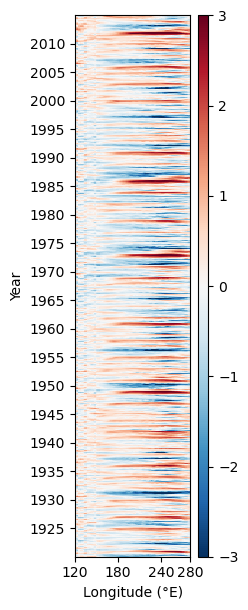

In [78]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ENSO import Polynomial_Detrend
'''
equatorial mean(1d) -> remove seasonal(1d) -> detrend(1d)
instead of 
remove seasonal(2d) -> detrend(2d) -> equatorial mean(1d)
'''
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")
sst_eq_1d = ds['sst']

# Remove seasonal cycle (monthly climatology over a reference period)
with xr.open_dataset("../data/sst.mnmean.nc") as ds_obs:
    sst_eq_1d_obs = weighted_mean(ds_obs.sst.sel(time=slice("1920-01", "2020-12"), lon=slice(120, 280), lat=slice(5, -5)))
    clim_ref = ("1981-01", "2010-12")
    clim = sst_eq_1d_obs.sel(time=slice(*clim_ref)).groupby("time.month").mean("time", skipna=True)
    anoms_eq_1d = sst_eq_1d.groupby("time.month") - clim

# Linear detrend per grid cell (along time)
def _poly_detrend_1d(x, degree=1):
    if np.all(np.isnan(x)):
        return x
    model = Polynomial_Detrend(degree=degree)
    model.fit(x[:, np.newaxis])
    t_points = np.arange(len(x))
    trend = model.predict(t_points).ravel()
    return x - trend
anoms_eq_1d = xr.apply_ufunc(
    _poly_detrend_1d, anoms_eq_1d,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[anoms_eq_1d.dtype]
)

nino34 = anoms_eq_1d.sel(lon=slice(190, 240)).mean(dim=('lon')).rolling(time=3, center=True).mean()

# Hovmöller plot
fig, ax = plt.subplots(figsize=(2.5, 6.2))  # wider than tall usually looks better
anoms_eq_1d = anoms_eq_1d.transpose("time", "lon") # Ensure C has shape (Ny, Nx) = (len(time), len(lon))
pcm = ax.pcolormesh(
    anoms_eq_1d["lon"].values,                # X (Nx)
    pd.to_datetime(anoms_eq_1d["time"].values), # Y (Ny)
    anoms_eq_1d.values,                                # C (Ny, Nx)
    cmap="RdBu_r",
    shading="auto",
    vmin=-3, vmax=3
)
cb = plt.colorbar(pcm, ax=ax, aspect=50)
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Year")
ax.yaxis.set_major_locator(mdates.YearLocator(5))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xticks([120, 180, 240, 280])
ax.set_xlim(120, 280)
plt.tight_layout()
plt.savefig('../figure/hovmoller_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.png', dpi=150)
plt.show()

In [79]:
ds_out = xr.Dataset(
    data_vars={
        "eq_ssta": anoms_eq_1d,  # (lon, time)
        # "ssta": anoms,  # (lon, time)
        "nino34": nino34,          # (time)
    }
)
ds_out.attrs.update({
    "title": "cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014 Equatorial SSTA and Niño 3.4",
    "climatology_ref": "1981-01 to 2010-12 from ersstv5" ,
    "notes": "equatorial mean(1d) -> remove seasonal(1d) -> detrend(1d)",
})

out_path = "../data/ssta_nino34_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_1d.nc"
ds_out.to_netcdf(out_path, format="NETCDF4", mode="w")
print(f"Saved to {out_path}")

Saved to ../data/ssta_nino34_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_1d.nc


### FCM

Classify the model data into regimes using the saved clustering model.

In [81]:
import numpy as np
import xarray as xr
import pickle
from cluster import FCMEntropy, reorder_labels_by_mean_nino34

file = xr.open_dataset("../data/ssta_nino34_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_1d.nc")
data = file["eq_ssta"].to_numpy()
nino34 = file["nino34"].to_numpy()
train_size = 1212 # training data size
val_size = 0
test_size = 0 # test data size

with open('../data/fcm_ersstv5_1d.pkl', 'rb') as f:
    fcm_model_data = pickle.load(f)
cluster_model = FCMEntropy(**fcm_model_data['config'])
cluster_model.centers = fcm_model_data['centers']
cluster_model.weights = fcm_model_data['weights']
scaler = fcm_model_data['scaler']

L = 1 # time delay steps
data = data[:train_size]
Nt, _ = data.shape # currently only SSTA
features = []
features.append(np.mean(np.stack([data[i:Nt+i-L+1] for i in range(L)], axis=2), axis=2)) # (SSTA window mean)
# features.append(np.mean(np.stack([np.abs(data[i:Nt-L+i+1]-data[i-1:Nt-L+i]) for i in range(1,L)], axis=2), axis=2)) # (|SSTA difference|)
# optional: CP, EP: nino4, nino3
# optional: SSH (unobserved)
data_embedded = np.concatenate(features, axis=1)
data_scaled = scaler.transform(data_embedded)
weights = cluster_model.predict(data_scaled)
labels = np.argmax(weights, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

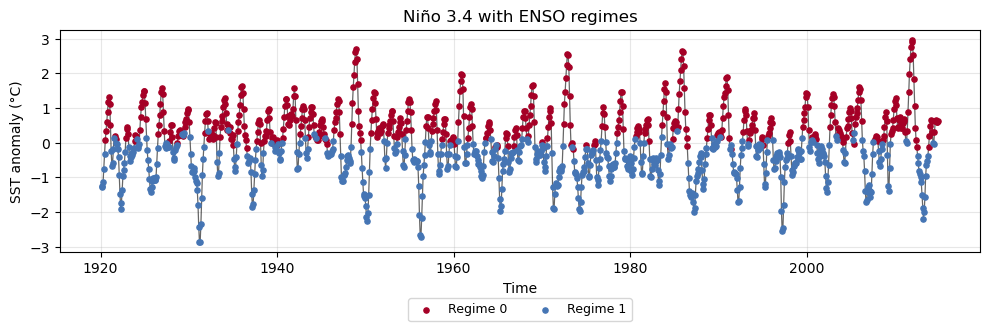

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_nino34_with_regimes

colors = [
    "#a50026",  # deep red
    # "#f46d43",  # orange-red
    # "#fee090",  # light orange
    # "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_1d.png')
plt.show()

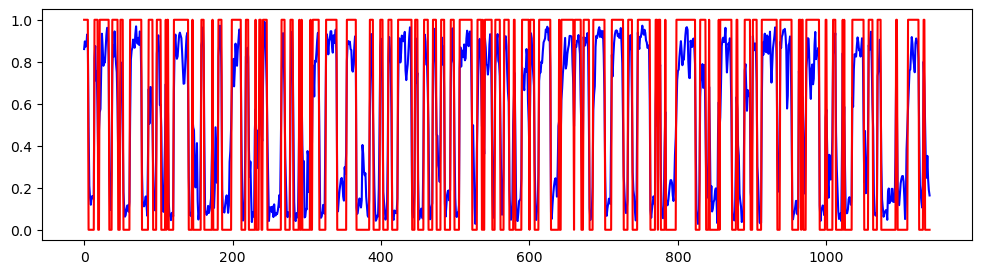

In [96]:
fig = plt.figure(figsize=(12,3))
plt.plot(weights[:,0], 'b')
plt.plot(new_labels, 'r')

Using SSTA as the only feature input to FCM may not be a good choice. Because the warmer/colder regime is only a 'phase' of the dynamics, not necessarily a 'regime'.

In [94]:
import numpy as np
import xarray as xr
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")
arrays = [ds[v] for v in ds.data_vars] # shape: (var=5, time=1140, lon=81)
data = xr.concat(arrays, dim='var').transpose('time', 'var', 'lon').values

In [100]:
from cluster import denoise_and_extract_slices
S_clean, slices_by_regime, segments_by_regime = denoise_and_extract_slices(new_labels, data[L-1:], min_duration=3)

for regime in sorted(slices_by_regime):
    print(f"\nRegime {regime}:")
    for (start, end), d in zip(segments_by_regime[regime], slices_by_regime[regime]):
        print(f"  Segment [{start}:{end}], shape = {d.shape}")

np.savez("../data/cmip6_ACCESS-CM2_1d_regime_data.npz",
         S_clean=S_clean,
         S_obs=new_labels,
         slices_by_regime=slices_by_regime,
         segments_by_regime=segments_by_regime,
         allow_pickle=True)


Regime 0:
  Segment [6:14], shape = (8, 5, 81)
  Segment [34:38], shape = (4, 5, 81)
  Segment [46:49], shape = (3, 5, 81)
  Segment [53:62], shape = (9, 5, 81)
  Segment [78:87], shape = (9, 5, 81)
  Segment [93:98], shape = (5, 5, 81)
  Segment [104:121], shape = (17, 5, 81)
  Segment [141:158], shape = (17, 5, 81)
  Segment [162:181], shape = (19, 5, 81)
  Segment [186:199], shape = (13, 5, 81)
  Segment [212:218], shape = (6, 5, 81)
  Segment [222:236], shape = (14, 5, 81)
  Segment [247:266], shape = (19, 5, 81)
  Segment [271:278], shape = (7, 5, 81)
  Segment [282:308], shape = (26, 5, 81)
  Segment [317:326], shape = (9, 5, 81)
  Segment [341:354], shape = (13, 5, 81)
  Segment [367:385], shape = (18, 5, 81)
  Segment [390:399], shape = (9, 5, 81)
  Segment [403:410], shape = (7, 5, 81)
  Segment [415:423], shape = (8, 5, 81)
  Segment [442:446], shape = (4, 5, 81)
  Segment [450:458], shape = (8, 5, 81)
  Segment [464:470], shape = (6, 5, 81)
  Segment [475:481], shape = (6, 

(0.0, 200.0)

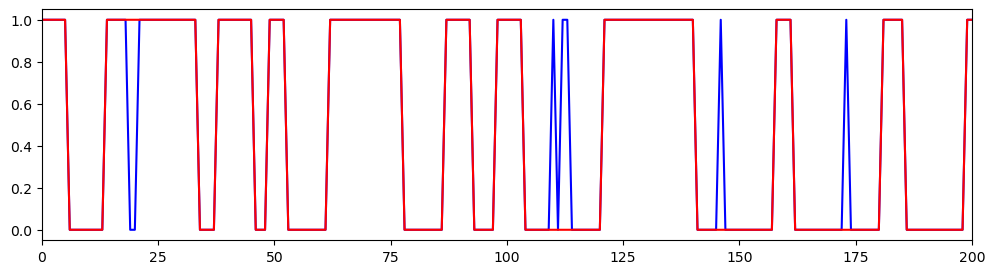

In [105]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,3))
plt.plot(new_labels, 'b')
plt.plot(S_clean, 'r')
plt.xlim(0,200)

## Surrogate modeling: CNN+LSTM

In [73]:
import torch.nn.functional as F
from ENSO import CNNLSTMTrainer

def debug_encoder_forward(encoder, x):
    print(f"[Encoder] input: {tuple(x.shape)}")
    y = encoder.pre(x);        print(f"  after pre : {tuple(y.shape)}")
    y = encoder.down(y);    print(f"  after down : {tuple(y.shape)}")
    y = encoder.proj(y);    print(f"  after proj : {tuple(y.shape)}")
    y = encoder.block(y);   print(f"  after block: {tuple(y.shape)}")
    y = encoder.se(y);      print(f"  after SE   : {tuple(y.shape)}")
    y = encoder.post(y);    print(f"  after post : {tuple(y.shape)}")
    if y.shape[-1] != encoder.latent_dim:
        print(f"  pool to latent_dim: {y.shape[-1]} -> {encoder.latent_dim}")
        y = F.adaptive_avg_pool1d(y, encoder.latent_dim)
        print(f"  after pool: {tuple(y.shape)}")
    print(f"[Encoder] output: {tuple(y.shape)}")
    return y

def debug_decoder_forward(decoder, h):
    print(f"[Decoder] input: {tuple(h.shape)}")
    y = decoder.pre(h);       print(f"  after pre  : {tuple(y.shape)}")
    y = decoder.se(y);        print(f"  after SE   : {tuple(y.shape)}")
    y = decoder.block(y);     print(f"  after block: {tuple(y.shape)}")
    y = decoder.proj(y);      print(f"  after proj : {tuple(y.shape)}")
    y = decoder.up(y);        print(f"  after up   : {tuple(y.shape)}")
    y = decoder.post(y);        print(f"  after post   : {tuple(y.shape)}")
    if y.shape[-1] != decoder.Nx:
        print(f"  interp to Nx: {y.shape[-1]} -> {decoder.Nx}")
        y = F.interpolate(y, size=decoder.Nx, mode='linear', align_corners=False)
        print(f"  after interp: {tuple(y.shape)}")
    print(f"[Decoder] output: {tuple(y.shape)}")
    return y

encoder = Encoder1D(in_channels=5, out_channels=40, hidden_channels=20, Nx=81, latent_dim=20)
decoder = Decoder1D(in_channels=40, out_channels=5, hidden_channels=20, Nx=81, latent_dim=20)

# Encoder debug
x = torch.randn(100, 5, 81)
z = debug_encoder_forward(encoder, x)

# Decoder debug
y = debug_decoder_forward(decoder, z)  # or any latent (B, C_latent, D_latent)

[Encoder] input: (100, 5, 81)
  after pre : (100, 20, 81)
  after down : (100, 40, 20)
  after proj : (100, 40, 20)
  after block: (100, 40, 20)
  after SE   : (100, 40, 20)
  after post : (100, 40, 20)
[Encoder] output: (100, 40, 20)
[Decoder] input: (100, 40, 20)
  after pre  : (100, 40, 20)
  after SE   : (100, 40, 20)
  after block: (100, 40, 20)
  after proj : (100, 40, 20)
  after up   : (100, 20, 80)
  after post   : (100, 5, 80)
  interp to Nx: 80 -> 81
  after interp: (100, 5, 81)
[Decoder] output: (100, 5, 81)


### Single model

Including ssh, taux, tauy, nhf as input to NNs is helpful (validated).

In [121]:
import numpy as np
import xarray as xr
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")

arrays = [ds[v] for v in ds.data_vars] # shape: (var=5, time=1140, lon=81)
data = xr.concat(arrays, dim='var').transpose('time', 'var', 'lon').values

train size: 911, val size: 113, test size: 115
Encoder #parameters: 44,485
LSTM    #parameters: 29,736
Decoder #parameters: 44,245
TOTAL   #parameters: 118,466 (trainable 118,466)
Epoch 0: Train 0.585950 | Val  0.240082 | Time 0.0226 mins ✅
Epoch 1: Train 0.204021 | Val  0.171717 | Time 0.0223 mins ✅
Epoch 2: Train 0.154525 | Val  0.141105 | Time 0.0230 mins ✅
Epoch 3: Train 0.135096 | Val  0.125148 | Time 0.0230 mins ✅
Epoch 4: Train 0.119635 | Val  0.125545 | Time 0.0217 mins 
Epoch 5: Train 0.114887 | Val  0.111162 | Time 0.0226 mins ✅
Epoch 6: Train 0.103681 | Val  0.114754 | Time 0.0217 mins 
Epoch 7: Train 0.099507 | Val  0.105444 | Time 0.0226 mins ✅
Epoch 8: Train 0.095057 | Val  0.095829 | Time 0.0230 mins ✅
Epoch 9: Train 0.093434 | Val  0.094339 | Time 0.0229 mins ✅
Epoch 10: Train 0.089996 | Val  0.099267 | Time 0.0219 mins 
Epoch 11: Train 0.085054 | Val  0.091360 | Time 0.0227 mins ✅
Epoch 12: Train 0.083445 | Val  0.091392 | Time 0.0216 mins 
Epoch 13: Train 0.080683 | V

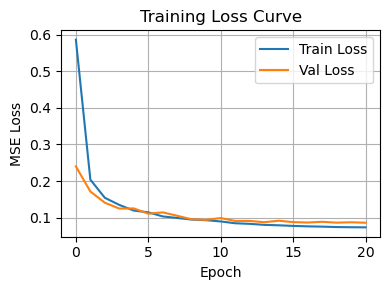

Test Loss (normalized space) = 0.102544


In [126]:
from ENSO import CNNLSTMTrainer
trainer = CNNLSTMTrainer(data, seq_len=1, in_channels=5, out_channels=5, 
                         latent_channels=40, hidden_channels=10, latent_dim=20, 
                         lstm_hidden_dim=64, lstm_layers=1,
                         batch_size=20, num_epochs=20, lr=1e-3)
trainer.train(
    save_dir_loss='../model/enso_cnnlstm_cmip6_ACCESS-CM2_1d_train_losses.npy',
    save_dir_model='../model/enso_cnnlstm_cmip6_ACCESS-CM2_1d.pt'
)
test_pred = trainer.test(return_physical=True)
# test_pred = trainer.test(pretrain=True, pretrain_dir='../model/enso_cnnlstm_cmip6_ACCESS-CM2_1d.pt', return_physical=True)

In [130]:
import numpy as np
test_size = 115
sst_pred = test_pred[:, 0]
ssh_pred = test_pred[:, 1]
taux_pred = test_pred[:, 2]
tauy_pred = test_pred[:, 3]
nhf_pred = test_pred[:, 4]

sst_truth = data[-test_size:, 0]
ssh_truth = data[-test_size:, 1]
taux_truth = data[-test_size:, 2]
tauy_truth = data[-test_size:, 3]
nhf_truth = data[-test_size:, 4]

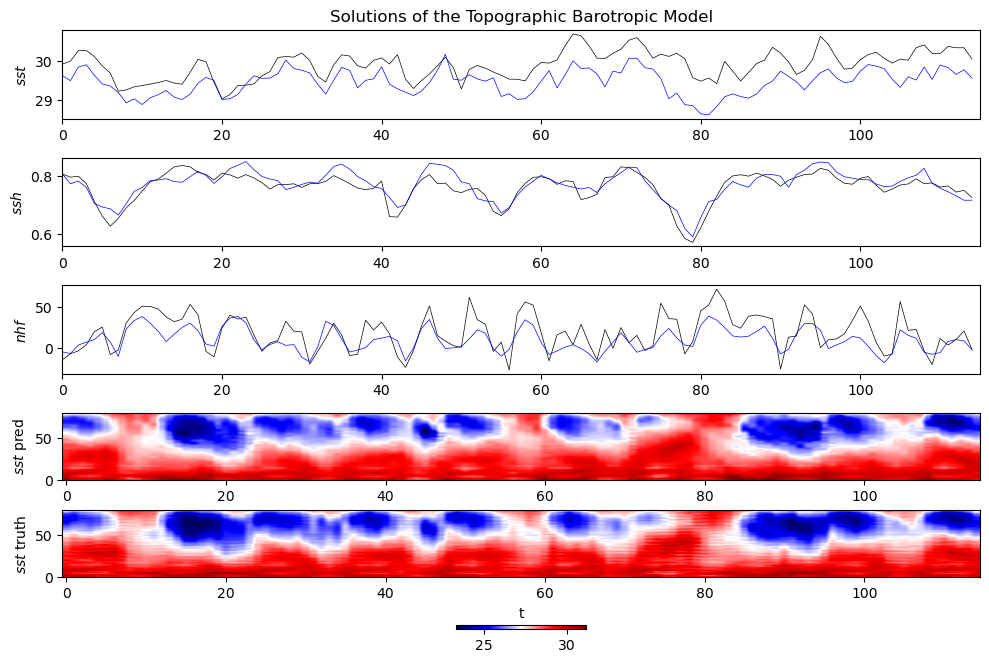

In [10]:
import matplotlib.pyplot as plt
def plot_baro_series(dt, sel0, sel1, interv, xlim,
                           data_groups, v_field, T_field, labels, colors, var_names = [r'$U$', r'$\hat{v}_1$', r'$\hat{T}_1$']):
    """
    Plot time series, PDFs (log-scale), and ACFs.
    Layout: 3 rows (variables), 3 columns (time series | PDF | ACF)
    
    Parameters:
    - *_list: list of arrays of shape (T,)
    - sel0, sel1: time index range
    - interv: interval for time series downsampling
    - xlim: x-axis limits for time plots
    - ylim: x-axis limits for PDF plots (log x-scale)
    """

    xaxis = np.arange(sel0 * dt, sel1 * dt, interv * dt)

    fig = plt.figure(figsize=(10, 7))
    widths = [1]
    heights = [1, 1, 1, 1, 1]
    spec = fig.add_gridspec(nrows=5, ncols=1, width_ratios=widths, height_ratios=heights)
    plt.subplots_adjust(wspace=0.5, hspace=0.6)

    legend_lines = []
    legend_labels = []

    for row, (var_list, var_label) in enumerate(zip(data_groups, var_names)):
        ax_ts  = fig.add_subplot(spec[row, 0])  # Time series

        for i, data in enumerate(var_list):
            samples = data[sel0:sel1]
            series = data[sel0:sel1:interv]

            # --- Time Series ---
            line_model, = ax_ts.plot(xaxis, series, color=colors[i], label=labels[i], linewidth=.5)
            if row == 0 and i == 0:  # only track lines from the first row to avoid duplicates
                legend_lines.append(line_model)
                legend_labels.append(labels[i])
        
        # Axis labels/titles
        ax_ts.set_xlim(xlim)
        ax_ts.set_ylabel(var_label)
        # ax_ts.set_xlabel("t")
        if row == 0:
            ax_ts.set_title("Solutions of the Topographic Barotropic Model")


    # --- 4: v(x, t) field ---
    ax_vfield = fig.add_subplot(spec[3, 0])
    im1 = ax_vfield.imshow(
        v_field[sel0:sel1, :].T,
        origin='lower',
        aspect='auto',
        # extent=[sel0 * dt, sel1 * dt, 0, np.pi*2],
        # vmin=-10, vmax=10, 
        cmap='seismic'
    )
    ax_vfield.set_ylabel(r'$sst$ pred')
    # fig.colorbar(im1, ax=ax_vfield, shrink=0.9, pad=0.1, fraction=0.005)

    # --- 5: T(x, t) field ---
    ax_Tfield = fig.add_subplot(spec[4, 0])
    im2 = ax_Tfield.imshow(
        T_field[sel0:sel1, :].T,
        origin='lower',
        aspect='auto',
        # extent=[sel0 * dt, sel1 * dt, 0, np.pi*2],
        # vmin=-10, vmax=10, 
        cmap='seismic'
    )
    ax_Tfield.set_ylabel(r'$sst$ truth')
    ax_Tfield.set_xlabel("t")
    # fig.colorbar(im2, ax=ax_Tfield, shrink=0.9, pad=0.01, fraction=0.005)

    plt.tight_layout(rect=[0, 0.01, 1, 1])

    cbar = fig.colorbar(im2, ax=[ax_vfield, ax_Tfield], orientation='horizontal',
                        location='bottom', pad=0.22, fraction=0.02, aspect=30)
    # # Global legend
    # fig.legend(legend_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
    #            ncol=len(legend_labels), fontsize=8)
    # plt.tight_layout(rect=[0, 0, 1, 0.97])

ind_x = 10
plot_baro_series(
    dt=1,
    sel0=0,
    sel1=115,
    interv=1,
    xlim=(0, 115),
    data_groups= [[sst_truth[:, ind_x], sst_pred[:, ind_x]], [ssh_truth[:, ind_x], ssh_pred[:, ind_x]], [nhf_truth[:, ind_x], nhf_pred[:, ind_x]]],
    v_field = sst_truth,
    T_field = sst_pred,
    labels=["truth", "pred"],
    colors=["k", "b"],
    var_names=[r'$sst$', r'$ssh$', r'$nhf$']
)

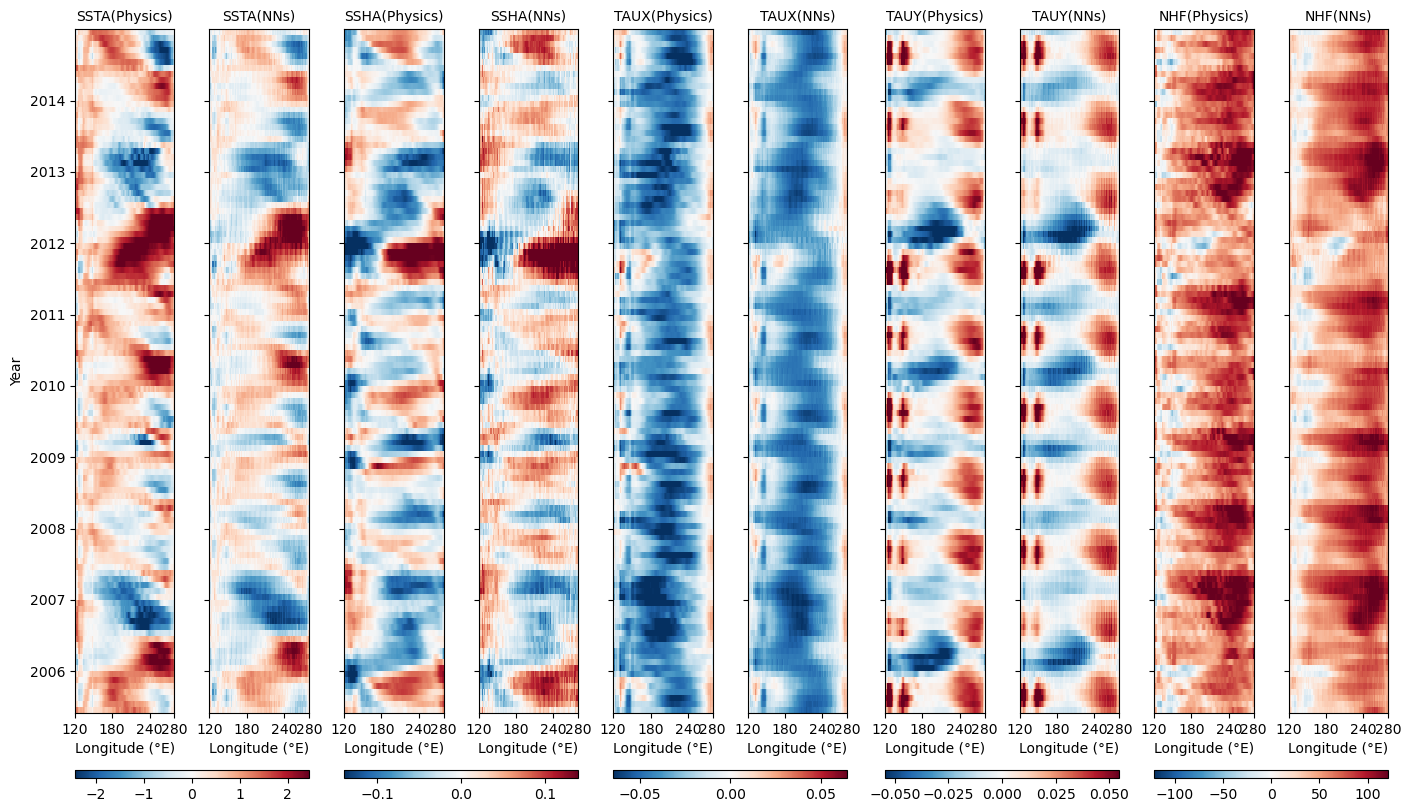

In [30]:
import matplotlib.pyplot as plt
from ENSO import Polynomial_Detrend

train_size = 911
val_size = 113
test_size = 115
truth = data[-test_size:].copy()   # (T, 5, Nx)
pred = test_pred.copy()   # (T, 5, Nx)

# calculate anomalies of SST and SSH
t_points = np.arange(train_size+val_size, train_size+val_size+test_size)
detrend_model = Polynomial_Detrend(degree=1)
for i in range(2):
    detrend_model.fit(data[:train_size, i, :])
    truth[:, i] = detrend_model.detrend(t_points, truth[:, i])
    pred[:, i] = detrend_model.detrend(t_points, pred[:, i])
    
var_names = ['ssta', 'ssha', 'taux', 'tauy', 'nhf']
from plot import hovmoller_compare
hovmoller_compare(truth, pred, ds, var_names)
plt.savefig('../figure/hovmoller_enso_cnnlstm_cmip6_ACCESS-CM2_1d.png', dpi=150)
plt.show()

### Multiple models

In [1]:
import numpy as np
data = np.load("../data/cmip6_ACCESS-CM2_1d_regime_data.npz", allow_pickle=True)
slices_by_regime = data["slices_by_regime"].item()
segments_by_regime = data["segments_by_regime"].item()

train size: 43, val size: 5, test size: 6
Encoder #parameters: 44,485
LSTM    #parameters: 29,736
Decoder #parameters: 44,245
TOTAL   #parameters: 118,466 (trainable 118,466)
Epoch 0: Train 0.594853 | Val  0.268430 | Time 0.0291 mins ✅
Epoch 1: Train 0.215584 | Val  0.225770 | Time 0.0231 mins ✅
Epoch 2: Train 0.163441 | Val  0.161027 | Time 0.0232 mins ✅
Epoch 3: Train 0.145424 | Val  0.159771 | Time 0.0230 mins ✅
Epoch 4: Train 0.136797 | Val  0.149747 | Time 0.0232 mins ✅
Epoch 5: Train 0.130078 | Val  0.144180 | Time 0.0233 mins ✅
Epoch 6: Train 0.125071 | Val  0.134503 | Time 0.0233 mins ✅
Epoch 7: Train 0.110923 | Val  0.130400 | Time 0.0231 mins ✅
Epoch 8: Train 0.109090 | Val  0.125222 | Time 0.0234 mins ✅
Epoch 9: Train 0.101844 | Val  0.117792 | Time 0.0232 mins ✅
Epoch 10: Train 0.095800 | Val  0.113112 | Time 0.0232 mins ✅
Epoch 11: Train 0.092638 | Val  0.112881 | Time 0.0231 mins ✅
Epoch 12: Train 0.091307 | Val  0.110187 | Time 0.0233 mins ✅
Epoch 13: Train 0.088106 | Va

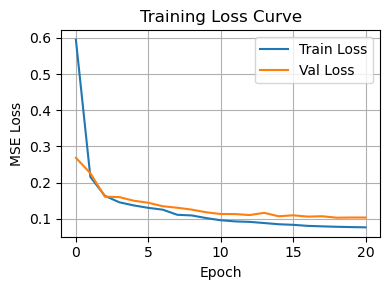

Test Loss (normalized space) = 0.107734
train size: 43, val size: 5, test size: 6
Encoder #parameters: 44,485
LSTM    #parameters: 29,736
Decoder #parameters: 44,245
TOTAL   #parameters: 118,466 (trainable 118,466)
Epoch 0: Train 0.537648 | Val  0.241727 | Time 0.0245 mins ✅
Epoch 1: Train 0.195907 | Val  0.167830 | Time 0.0242 mins ✅
Epoch 2: Train 0.156937 | Val  0.150126 | Time 0.0248 mins ✅
Epoch 3: Train 0.140315 | Val  0.128541 | Time 0.0247 mins ✅
Epoch 4: Train 0.126408 | Val  0.129751 | Time 0.0235 mins 
Epoch 5: Train 0.120181 | Val  0.119627 | Time 0.0245 mins ✅
Epoch 6: Train 0.110754 | Val  0.111892 | Time 0.0249 mins ✅
Epoch 7: Train 0.104895 | Val  0.110067 | Time 0.0248 mins ✅
Epoch 8: Train 0.099720 | Val  0.109797 | Time 0.0250 mins ✅
Epoch 9: Train 0.099853 | Val  0.112133 | Time 0.0235 mins 
Epoch 10: Train 0.095227 | Val  0.116416 | Time 0.0233 mins 
Epoch 11: Train 0.090477 | Val  0.097448 | Time 0.0245 mins ✅
Epoch 12: Train 0.084671 | Val  0.098751 | Time 0.0237

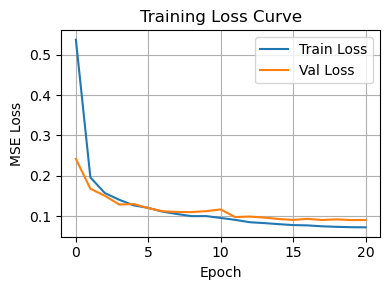

Test Loss (normalized space) = 0.099109


In [11]:
import numpy as np
data = np.load("../data/cmip6_ACCESS-CM2_1d_regime_data.npz", allow_pickle=True)
slices_by_regime = data["slices_by_regime"].item()

# from ENSO import CNNLSTMTrainer
# regime 0
trainer = CNNLSTMTrainer(piecewise=True, data_segments=slices_by_regime[0], seq_len=1, in_channels=5, out_channels=5, 
                         latent_channels=40, hidden_channels=10, latent_dim=20, 
                         lstm_hidden_dim=64, lstm_layers=1,
                         batch_size=8, num_epochs=20, lr=1e-3)
trainer.train(
    save_dir_loss='../model/enso_cnnlstm_regime0_cmip6_ACCESS-CM2_1d_train_losses.npy',
    save_dir_model='../model/enso_cnnlstm_regime0_cmip6_ACCESS-CM2_1d.pt'
)
test_pred_r0 = trainer.test(return_physical=True)

# regime 1
trainer = CNNLSTMTrainer(piecewise=True, data_segments=slices_by_regime[1], seq_len=1, in_channels=5, out_channels=5, 
                         latent_channels=40, hidden_channels=10, latent_dim=20, 
                         lstm_hidden_dim=64, lstm_layers=1,
                         batch_size=8, num_epochs=20, lr=1e-3)
trainer.train(
    save_dir_loss='../model/enso_cnnlstm_regime1_cmip6_ACCESS-CM2_1d_train_losses.npy',
    save_dir_model='../model/enso_cnnlstm_regime1_cmip6_ACCESS-CM2_1d.pt'
)
test_pred_r1 = trainer.test(return_physical=True)

In [120]:
test_pred_r0.shape

(97, 5, 81)

In [119]:
test_pred_r1.shape

(58, 5, 81)

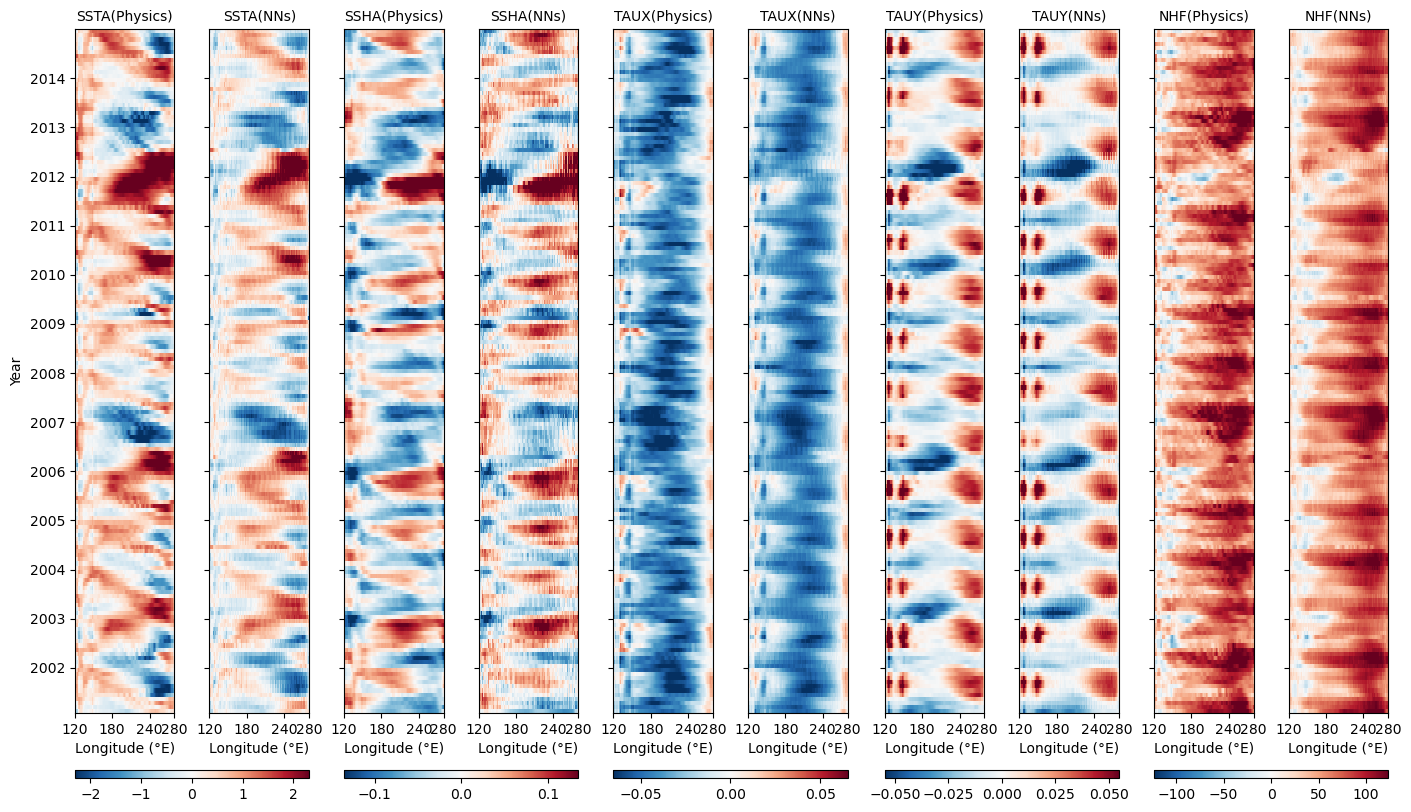

In [53]:
import matplotlib.pyplot as plt
from ENSO import Polynomial_Detrend
import numpy as np
import xarray as xr
import pandas as pd
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")
arrays = [ds[v] for v in ds.data_vars] # shape: (var=5, time=1140, lon=81)
data1 = xr.concat(arrays, dim='var').transpose('time', 'var', 'lon').values
Nt, Nv, Nx  = data1.shape

test_size = 6
seq_len = 1
test_pred = np.zeros((Nt, Nv, Nx))
test_preds = [test_pred_r0, test_pred_r1]
for reg in range(2):
    ind = 0
    for seg in segments_by_regime[reg][-test_size:]:
        len_seg = seg[1] - seg[0] - seq_len
        test_pred[seg[0]:seg[0]+seq_len] = data1[seg[0]:seg[0]+seq_len] # use truth for ghost predictor points in data sequence
        test_pred[seg[0]+seq_len:seg[1]] = test_preds[reg][ind:ind+len_seg]
        ind += len_seg

ind_start =  min(seg[0] for seg in segments_by_regime[reg][-test_size:] for reg in range(2))
truth = data1[ind_start:].copy()
pred = test_pred[ind_start:].copy()
time = pd.to_datetime(ds['time'].values[ind_start:])   # (T,)
lon  = np.asarray(ds['lon'].values)                    # (Nx,)

# calculate anomalies of SST and SSH
t_points = np.arange(ind_start, Nt)
detrend_model = Polynomial_Detrend(degree=1)
for i in range(2):
    detrend_model.fit(data1[:ind_start, i, :])
    truth[:, i] = detrend_model.detrend(t_points, truth[:, i])
    pred[:, i] = detrend_model.detrend(t_points, pred[:, i])
    
var_names = ['ssta', 'ssha', 'taux', 'tauy', 'nhf']
from plot import hovmoller_compare
hovmoller_compare(truth, pred, time, lon, var_names)
plt.savefig('../figure/hovmoller_enso_cnnlstm_2regimes_cmip6_ACCESS-CM2_1d.png', dpi=150)
plt.show()

# Multi-model EnKF

In [4]:
class AutoRegressiveModel:
    def __init__(self, regime_models=[1], scalers=None, routing_matrix=None, holding_parameters=None, device=None):
        """
        Initialize autoregressive regime models with CTMC-based regime switching.
        
        Args:
            regime_models (list of nn.Module): List of models, one per regime.
            routing_matrix (np.ndarray): CTMC routing_matrix matrix of shape (n_regimes, n_regimes).
            holding_parameters (list or np.ndarray): Holding rates (lambda) for each regime.
            device (str or torch.device): Device to run the simulation on.
        """
        self.regime_models = regime_models
        self.scalers = scalers
        self.routing_matrix = routing_matrix
        self.holding_parameters = holding_parameters
        self.n_regimes = len(regime_models)
        self.device = device

    def forecast(self, Nt, dt, x0, S0):
        """
        Simulate a single trajectory with autoregressive regime-switching models.
        
        Args:
            N (int): Number of forecast steps.
            dt (float): Time step size.
            x0 (torch.Tensor): Initial input of shape (seq_len, channel, input_dim).
            S0 (int): Initial regime index.
        
        Returns:
            x (np.ndarray): Forecasted trajectory, shape (N+1, channel, input_dim).
            S (np.ndarray): Regime path, shape (N+1,)
        """
        # x0 = x0.to(self.device)
        x0 = np.expand_dims(x0, axis=0) # (1, seq_len, channel, input_dim)
        # x0 = x0.unsqueeze(0) # (1, seq_len, channel, input_dim)
        x = np.zeros((1, Nt+1, *x0.shape[-2:]))
        S = np.zeros(Nt+1, dtype=int)
        x[:, 0], S[0] = x0[:, -1], S0
        preds = []

        with torch.no_grad():
            for n in range(1, Nt+1):
                current_regime = S[n - 1]
                holding_param = self.holding_parameters[current_regime]

                # Regime switching
                if np.random.rand() < holding_param * dt:
                    S[n] = np.random.choice(self.n_regimes, p=self.routing_matrix[current_regime])
                else:
                    S[n] = current_regime

                model = self.regime_models[current_regime]
                scaler = self.scalers[current_regime]
                model.eval()
                x[:, n] = scaler.inverse(model(torch.from_numpy(x0.astype(np.float32)).to(self.device))).cpu().numpy()
                x0 = np.concatenate((x0[:, 1:], x[:, n:n+1]), axis=1)

        return x[0], S

    def ensemble_forecast(self, Nt, dt, x0, S0, ensemble_size):
        """
        Simulate an ensemble of regime-switching forecasts.
        
        Args:
            N (int): Number of forecast steps.
            dt (float): Time step size.
            x0 (torch.Tensor): Initial inputs, shape (ensemble_size, seq_len, channel, input_dim).
            S0 (array-like): Initial regimes, shape (ensemble_size,)
            ensemble_size (int): Number of ensemble members.
        
        Returns:
            X (np.ndarray): Forecast trajectories, shape (ensemble_size, N+1, channel, input_dim)
            S (np.ndarray): Regime paths, shape (ensemble_size, N+1)
        """
        X = np.zeros((ensemble_size, Nt+1, *x0.shape[-2:]))
        S = np.zeros((ensemble_size, Nt+1), dtype=int)
        X[:, 0, :] = x0[:, -1, :]
        S[:, 0] = S0
        # x0 = x0.to(self.device)

        for i in range(ensemble_size):
            xi, Si = self.forecast(Nt, dt, x0[i], S0[i])
            X[i], S[i] = xi, Si

        return X, S


#### Multi-model EnKF based on Regimes

##### Imperfect clustering with FCM

In [39]:
clim.values.shape

(12, 81)

In [2]:
def weighted_mean(data):
    # weighted mean using area weights (cos(lat))
    w_lat = np.cos(np.deg2rad(data["lat"])) 
    w2d = w_lat.broadcast_like(data.isel(time=0))  # (lat, lon)
    num = (data * w2d).sum(dim="lat", skipna=True)
    den = w2d.where(data.notnull()).sum(dim="lat", skipna=True)
    mean = num / den  # (time × lon)
    return mean

In [5]:
########################## load data ############################
ds_truth = xr.open_dataset('../data/obs_sst_ssh_1d.nc') # 2005-07 to 2025-07
truth_full = xr.concat([ds_truth[v] for v in ds_truth.data_vars], dim='var').transpose('time', 'var', 'lon').values # take real obs as truth
# Generate observations by adding sythetic noises on top of the real obs
sigma_obs = 1
obs_full = truth_full[:, 0] + sigma_obs * np.random.randn(*truth_full[:, 0].shape) # SST obs
# data = np.load("../data/cmip6_ACCESS-CM2_1d_regime_data.npz", allow_pickle=True)
# S_obs_full = np.concatenate([np.zeros(20-1), data['S_clean']])
ds_ics = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")
ics_full = xr.concat([ds_ics[v] for v in ds_ics.data_vars], dim='var').transpose('time', 'var', 'lon').values

ics_full.shape

(1140, 5, 81)

In [25]:
class Polynomial_Detrend:
    def __init__(self, degree=1):
        """
        Fit polynomial trends along time for each spatial point.
        """
        self.degree = degree # degree of the polynomial. 1 = linear, 2 = quadratic, etc.
        self.coefs = None   # shape (Nx, degree+1)

    def fit(self, data):
        """
        data : np.ndarray, shape (T, Nx) Training data.
        """
        T, Nx = data.shape
        t = np.arange(T)  # time index
        self.coefs = np.empty((Nx, self.degree+1))
        for i in range(Nx):
            # polyfit handles NaNs poorly; skip or mask if needed
            y = data[:, i]
            mask = np.isfinite(y)
            if np.sum(mask) <= self.degree:
                self.coefs[i] = np.zeros(self.degree+1)
            else:
                self.coefs[i] = np.polyfit(t[mask], y[mask], deg=self.degree)
        return self
    
    def predict(self, t_points):
        """
        Predict trend on given time points (relative to training data).
        """
        t_points = np.asarray(t_points) # 1D array of time indices.
        print(self.coefs)
        Nx = self.coefs.shape[0]
        trend_pred = np.empty((len(t_points), Nx))
        for i in range(Nx):
            trend_pred[:, i] = np.polyval(self.coefs[i], t_points)
        return trend_pred

    def detrend(self, t_points, data):
        trend = self.predict(t_points)
        return data - trend

    def save(self, path: str):
        np.savez_compressed(path, degree=np.int64(self.degree), coefs=self.coefs)

    @classmethod
    def load(cls, path: str):
        data = np.load(path, allow_pickle=False)
        degree = int(data["degree"])
        coefs = np.asarray(data["coefs"])
        obj = cls(degree=degree)
        obj.coefs = coefs
        print(coefs)
        return obj


In [18]:
np.arange(3)*2

array([0, 2, 4])

In [16]:
ics.shape

(1140, 405)

In [14]:
truth.shape

(241, 162)

In [15]:
obs.shape

(241, 81)

In [10]:
np.tile(np.arange(3)[:, None], (1,2))

array([[0, 0],
       [1, 1],
       [2, 2]])

In [8]:
np.tile(np.arange(3)[:, None], (1,2)).reshape(6)

array([0, 0, 1, 1, 2, 2])

In [53]:
truth_full.shape

(241, 2, 81)

In [55]:
ics_full.shape

(1140, 5, 81)

In [52]:
########################## load data ############################
ds_truth = xr.open_dataset('../data/obs_sst_ssh_1d.nc') # 2005-07 to 2025-07
truth_full = xr.concat([ds_truth[v] for v in ds_truth.data_vars], dim='var').transpose('time', 'var', 'lon').values # take real obs as truth
# Generate observations by adding sythetic noises on top of the real obs
sigma_obs = 1
obs_full = truth_full[:, 0] + sigma_obs * np.random.randn(*truth_full[:, 0].shape) # SST obs
# data = np.load("../data/cmip6_ACCESS-CM2_1d_regime_data.npz", allow_pickle=True)
# S_obs_full = np.concatenate([np.zeros(20-1), data['S_clean']])
ds_ics = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")
ics_full = xr.concat([ds_ics[v] for v in ds_ics.data_vars], dim='var').transpose('time', 'var', 'lon').values

# Non-dimensionalize
scales = np.array([4, 0.2, 0.1, 0.1, 50]) # SST, SSH, Tau_x, Tau_y, NHF
truth_full = truth_full / scales[:2][None, :, None]
obs_full = obs_full / scales[0]


In [56]:
ics_full = ics_full / scales[None, :, None]


In [57]:
print('SST min/max', np.min(ics_full[:, 0]), np.max(ics_full[:, 0]))
print('SSH min/max', np.min(ics_full[:, 1]), np.max(ics_full[:, 1]))
print('Taux min/max', np.min(ics_full[:, 2]), np.max(ics_full[:, 2]))
print('Tauy min/max', np.min(ics_full[:, 3]), np.max(ics_full[:, 3]))
print('NHF min/max', np.min(ics_full[:, 4]), np.max(ics_full[:, 4]))

SST min/max 5.198414504305908 7.959847877051645
SSH min/max 0.823882101171677 4.990319905706637
Taux min/max -0.932755797563537 0.6655777265254501
Tauy min/max -0.9035062347216624 1.5243483820047612
NHF min/max -2.015302110879378 3.4860432656080405


In [54]:
print('SST min/max', np.min(truth_full[:, 0]), np.max(truth_full[:, 0]))
print('SSH min/max', np.min(truth_full[:, 1]), np.max(truth_full[:, 1]))

SST min/max 5.562654495239258 7.660008430480957
SSH min/max 0.1326606783537241 4.053453004245951


In [89]:
import numpy as np
import torch
from enkf import eakf, construct_GC
from ENSO import CNNLSTM1D, ChannelZScoreScaler, Polynomial_Detrend#, AutoRegressiveModel
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy
from model_evaluation import evaluate_model
from scipy.linalg import expm
from collections import deque
import pickle
from time import time
import xarray as xr

def allocate_ensemble(ensemble_size, weights):
    '''input total ensemble size and model weights, return ensemble size for each model'''
    allocations = np.round(weights * ensemble_size).astype(int)
    excess = allocations.sum() - ensemble_size
    if excess > 0:
        max_idx = np.argmax(allocations)
        allocations[max_idx] -= excess
    elif excess < 0:
        min_idx = np.argmin(allocations)
        allocations[min_idx] -= excess  

    return allocations.tolist()

def reallocate_ens(initial_allocation, target_counts):
    '''reallocate ensemble members with minimal movements (pen for ensemble member, drawer for model)'''
    M = len(initial_allocation)
    initial_counts = [len(pens) for pens in initial_allocation]
    delta = [target_counts[i] - initial_counts[i] for i in range(M)]
    drawers = [list(pens) for pens in initial_allocation] # Create copy of allocation
    surplus = deque()
    deficit = deque()
    for i in range(M):
        if delta[i] < 0:
            surplus.append((i, -delta[i]))
        elif delta[i] > 0:
            deficit.append((i, delta[i]))
    while surplus and deficit:
        s_idx, s_amt = surplus[0]
        d_idx, d_amt = deficit[0]
        move_amt = min(s_amt, d_amt)
        for _ in range(move_amt):
            pen_id = drawers[s_idx].pop()
            drawers[d_idx].append(pen_id)
        # Update queue entries
        if s_amt > d_amt:
            surplus[0] = (s_idx, s_amt - move_amt)
            deficit.popleft()
        elif d_amt > s_amt:
            deficit[0] = (d_idx, d_amt - move_amt)
            surplus.popleft()
        else:
            surplus.popleft()
            deficit.popleft()

    return drawers

def markov_generator(mu0, muT, T):
    """
    Find a time-homogeneous generator matrix Q such that: muT ≈ mu0 @ expm(T * Q)
    Returns:
        Q_opt (np.ndarray): Optimal generator matrix (n x n)
        h (np.ndarray): Holding parameter (n,)
        R (np.ndarray): Routing matrix (n x n)
    """
    from scipy.optimize import minimize
    
    n = len(mu0)
    def objective(Q_flat):
        Q = Q_flat.reshape((n, n))
        P = expm(T * Q)
        mu_pred = mu0 @ P
        return np.sum((mu_pred - muT) ** 2)
    ineq_constr = {
        'type': 'ineq',
        'fun': lambda Q_flat: Q_flat.reshape((n, n))[~np.eye(n, dtype=bool)]
    }
    eq_constr = {
        'type': 'eq',
        'fun': lambda Q_flat: Q_flat.reshape((n, n)).sum(axis=1)
    }
    Q0 = np.random.rand(n, n)
    np.fill_diagonal(Q0, 0)
    Q0 = Q0 / Q0.sum(axis=1, keepdims=True)
    np.fill_diagonal(Q0, -Q0.sum(axis=1))
    Q0_flat = Q0.flatten()
    result = minimize(objective, Q0_flat, constraints=[ineq_constr, eq_constr], method='SLSQP')
    success = result.success
    if success:
        Q_opt = result.x.reshape((n, n))
        h = -np.diag(Q_opt)
        R = np.zeros_like(Q_opt)
        for i in range(len(Q_opt)):
            if h[i] > 0:
                R[i, :] = Q_opt[i, :] / h[i]
                R[i, i] = 0.0
        return Q_opt, h, R
    else:
        raise RuntimeError("Optimization failed: could not find a valid generator matrix.")
        
np.random.seed(0)
torch.manual_seed(0)

########################## load data ############################
ds_truth = xr.open_dataset('../data/obs_sst_ssh_1d.nc') # 2005-07 to 2025-07
truth_full = xr.concat([ds_truth[v] for v in ds_truth.data_vars], dim='var').transpose('time', 'var', 'lon').values # take real obs as truth
# Generate observations by adding sythetic noises on top of the real obs
sigma_obs = 1
obs_full = truth_full[:, 0] + sigma_obs * np.random.randn(*truth_full[:, 0].shape) # SST obs
# data = np.load("../data/cmip6_ACCESS-CM2_1d_regime_data.npz", allow_pickle=True)
# S_obs_full = np.concatenate([np.zeros(20-1), data['S_clean']])
ds_ics = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")
ics_full = xr.concat([ds_ics[v] for v in ds_ics.data_vars], dim='var').transpose('time', 'var', 'lon').values

# Non-dimensionalize
scales = np.array([4, 0.2, 0.1, 0.1, 50]) # SST, SSH, Tau_x, Tau_y, NHF
truth_full = truth_full / scales[:2][None, :, None]
obs_full = obs_full / scales[0]
ics_full = ics_full / scales[None, :, None]

# For calculating SSTA
# Seasonal cycle (monthly climatology over a reference period)
with xr.open_dataset("../data/sst.mnmean.nc") as ds_obs:
    sst_eq_1d_obs = weighted_mean(ds_obs.sst.sel(time=slice("1920-01", "2020-12"), lon=slice(120, 280), lat=slice(5, -5)))
    clim_ref = ("1981-01", "2010-12")
    clim = sst_eq_1d_obs.sel(time=slice(*clim_ref)).groupby("time.month").mean("time", skipna=True).values
# Linear detrend per grid cell (along time)
detrend_model = Polynomial_Detrend(degree=1).load("../model/detrend_cmip6_ACCESS-CM2_1d.npz") # Use observation fitted detrend model?

######################### clustering ############################
K = 2 # number of clusters (regimes)
L = 1 # time delay steps
# scaler = StandardScaler()
# data = np.load('../data/data_topobaro.npz')
# truth_full = np.concatenate((data['U_truth'][:,None], (data['v_hat_truth'][:, 1].real)[:,None], (data['T_hat_truth'][:, 1].real)[:,None]), axis=1)
# data = truth_full[:train_size]
# Nt, _ = data.shape
# features = []
# features.append(np.mean(np.stack([data[i:Nt+i-L+1, 0][:,None] for i in range(L)], axis=2), axis=2)) # (U)
# features.append(zero_crossing_rate(np.stack([data[i:Nt+i-L+1, 1] for i in range(L)], axis=1))[:,None]) # (oscillation frequency:v1)
# features.append(zero_crossing_rate(np.stack([data[i:Nt+i-L+1, 2] for i in range(L)], axis=1))[:,None]) # (oscillation frequency:T1)
# data_embedded = np.concatenate(features, axis=1)
# data_scaled = scaler.fit_transform(data_embedded) # standardize features

# # clustering
# cluster_model = FCMEntropy(num_clusters=K, m=1.8, lambda_e=1, num_steps=1000, seed=0)
# results = cluster_model.fit(data_scaled, optimizer='iterative')

# # save the clustering model
# fcm_model_data = {
#     'centers': cluster_model.centers,
#     'weights': cluster_model.weights,
#     'scaler': scaler,
#     'config': {
#         'num_clusters': cluster_model.num_clusters,
#         'm': cluster_model.m,
#         'lambda_e': cluster_model.lambda_e,
#     }}
# with open('../data/fcm_model_topobaro.pkl', 'wb') as f:
#     pickle.dump(fcm_model_data, f)

# load the clustering model
with open('../data/fcm_ersstv5_1d.pkl', 'rb') as f:
    fcm_model_data = pickle.load(f)
cluster_model = FCMEntropy(**fcm_model_data['config'])
cluster_model.centers = fcm_model_data['centers']
cluster_model.weights = fcm_model_data['weights']
scaler = fcm_model_data['scaler']

# """
######################### multi-model DA ###########################
truth = truth_full#.reshape(truth_full.shape[0], -1)
obs = obs_full#[:, None, :]
# S_obs = S_obs_full[train_size:train_size+test_size]
_, Nx = obs.shape
nvar_eval = truth_full.shape[1]

# ---------------------- model parameters ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_channels = 5; out_channels=5; latent_channels=40; hidden_channels=10
latent_dim=20; lstm_hidden_dim=64; lstm_layers=1; seq_len = 1

# Models
model0 = CNNLSTM1D(in_channels=in_channels, out_channels=out_channels, latent_channels=latent_channels, 
                                  hidden_channels=hidden_channels, Nx=Nx, latent_dim=latent_dim,
                                  lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
scaler0 = ChannelZScoreScaler()
checkpoint = torch.load("../model/enso_cnnlstm_regime0_cmip6_ACCESS-CM2_1d.pt", map_location=device, weights_only=False)
model0.load_state_dict(checkpoint["model_state_dict"])
scaler0.load_state_dict(checkpoint["scaler_state"])
model1 = CNNLSTM1D(in_channels=in_channels, out_channels=out_channels, latent_channels=latent_channels, 
                                  hidden_channels=hidden_channels, Nx=Nx, latent_dim=latent_dim,
                                  lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
scaler1 = ChannelZScoreScaler()
checkpoint = torch.load("../model/enso_cnnlstm_regime1_cmip6_ACCESS-CM2_1d.pt", map_location=device, weights_only=False)
model1.load_state_dict(checkpoint["model_state_dict"])
scaler1.load_state_dict(checkpoint["scaler_state"])
models = [model0, model1]
scalers = [scaler0, scaler1]
n_models = len(models) # number of models
n_regimes = n_models # number of regimes
dt = 1 # Time step size
# Nx = 81 # Number of grid points
Nv = 5 # Number of variables
mlocs = np.tile(np.arange(Nx), Nv)
nmod = mlocs.shape[0] # number of model variables

# Model error evaluation
model_error = False
# lead_time = 1 # one assimilation step
# params = (models, sigma_x, sigma_y, sigma_z)
# if model_error == True:
#     # weight_matrix, score_matrix, _ = evaluate_model(L63RegimeModel, params, S_obs, truth, Nt, N_gap, dt, lead_time, n_models, n_regimes, rho=.5, verbose=True)
#     # np.savez('../data/model_evaluation_L63.npz', 
#     #          weight_matrix=weight_matrix,
#     #          score_matrix=score_matrix,
#     #          models=models,
#     #          regimes=regimes
#     #         )
#     model_error_data = np.load('../data/model_evaluation_OU.npz')
#     weight_matrix = model_error_data['weight_matrix']

# ------------------- observation parameters ------------------
# sigma_obs = 1
obs_error_var = sigma_obs**2
dt_obs = 1
obs_freq_timestep = int(dt_obs / dt)
ylocs = np.arange(Nx) # sst
nobs = ylocs.shape[0]
nobstime = obs.shape[0]
R = np.eye(nobs) * obs_error_var
Hk = np.zeros((nobs, nmod))
for iobs in range(nobs):
    Hk[iobs, ylocs[iobs]] = 1.0

# ------------------------ DA parameters ------------------------
# analysis period
iobsbeg = 20
iobsend = nobstime
# eakf parameters
ensemble_size = 100
inflation_values = [1.2] # provide multiple values if for tuning
localization_values = [1] # provide multiple values if for tuning
ninf = len(inflation_values)
nloc = len(localization_values)
localize = 0 # localization: 1 for on / 0 for off
inflate = 1 # inflatin: 1 for on / 0 for off

# ---------------------- initialization -----------------------
ics = ics_full.reshape(ics_full.shape[0], -1)
n_ics = ics.shape[0]
weights = np.array([1/n_models] * n_models, dtype=float) # uniform initial weights
ensemble_sizes = allocate_ensemble(ensemble_size, weights)
ensemble_indices = [np.arange(start, start + size).tolist() for start, size in zip(np.cumsum([0] + ensemble_sizes[:-1]), ensemble_sizes)]
S0_ens = np.zeros(ensemble_size, dtype=int) # initial model
for m in range(n_models):
    S0_ens[ensemble_indices[m]] = m
ens0 = ics[np.random.randint(n_ics, size=ensemble_size)]
prior_rmses = np.zeros((nobstime, nvar_eval, ninf,nloc))
analy_rmses = np.zeros((nobstime, nvar_eval, ninf,nloc))
prior_errs = np.zeros((nvar_eval, ninf,nloc))
analy_errs = np.zeros((nvar_eval, ninf,nloc))
prior_rmse = np.zeros((nobstime,ninf,nloc))
analy_rmse = np.zeros((nobstime,ninf,nloc))
prior_err = np.zeros((ninf,nloc))
analy_err = np.zeros((ninf,nloc))
pattern_corr = np.zeros((nvar_eval, Nx, ninf, nloc))
month = 7
t_point = (2005-1920)*12+7-1

# ----------------------- assimilation -------------------------
for iinf in range(ninf):
    inflation_value = inflation_values[iinf]
    for iloc in range(nloc):
        localization_value = localization_values[iloc]

        prior_mean_model = np.zeros((nobstime, nmod, n_models))
        analy_mean_model = np.zeros((nobstime, nmod, n_models))
        prior_spread_model = np.zeros((nobstime, nmod, n_models))
        analy_spread_model = np.zeros((nobstime, nmod, n_models))
        prior_mean_mixture = np.zeros((nobstime, nmod))
        analy_mean_mixture = np.zeros((nobstime, nmod))
        prior_spread_mixture = np.zeros((nobstime, nmod))
        analy_spread_mixture = np.zeros((nobstime, nmod))
        prior_weights = np.zeros((nobstime, n_models))
        posterior_weights = np.zeros((nobstime, n_models))
        S_ens = np.zeros((nobstime, ensemble_size))
        ens = ens0

        t0 = time()
        for iassim in range(L-1, nobstime):
            # print(iassim)
            prior_weights[iassim] = weights
            S_ens[iassim] = S0_ens

            for m in range(n_models):
                if ensemble_sizes[m] == 0:
                    weights[m] = 0 # posterior weight equals to zero
                elif ensemble_sizes[m] == 1:
                    # (no posterior updates for model weight and ensemble member)
                    ens_m = ens[ensemble_indices[m]]
                    prior_mean_model[iassim, :, m] = np.mean(ens_m, axis=0)
                    prior_spread_model[iassim, :, m] = prior_spread_model[iassim-1, :, m]
                    analy_mean_model[iassim, :, m] = np.mean(ens_m, axis=0)
                    analy_spread_model[iassim, :, m] = analy_spread_model[iassim-1, :, m]
                    weights[m] = 0 # posterior weight equals to zero
                else:
                    ens_m = ens[ensemble_indices[m]]
                    prior_mean_m = np.mean(ens_m, axis=0)

                    # inflation RTPP
                    ens_m = prior_mean_m + (ens_m - prior_mean_m) * inflation_value if inflate == 1 else ens_m
                    # localization matrix        
                    CMat = construct_GC(localization_value, mlocs, ylocs)

                    # posterior model weights
                    obs_inc = obs[iassim] - Hk @ prior_mean_m
                    cov = Hk @ np.cov(ens_m.T) @ Hk.T + R
                    likelihood = 1/(np.sqrt(np.linalg.det(cov))) * np.exp(-0.5 * obs_inc @ np.linalg.inv(cov) @ obs_inc)
                    weights[m] = weights[m] * likelihood

                    # EnKF serial update
                    prior_mean_model[iassim, :, m] = prior_mean_m
                    prior_spread_model[iassim, :, m] = np.std(ens_m, axis=0, ddof=1)
                    ens_m = eakf(ensemble_sizes[m], nobs, ens_m, Hk, obs_error_var, localize, CMat, obs[iassim])
                    ens[ensemble_indices[m]] = ens_m
                    analy_mean_model[iassim, :, m] = np.mean(ens_m, axis=0)
                    analy_spread_model[iassim, :, m] = np.std(ens_m, axis=0, ddof=1)

            # normalize to get posterior weights
            weights = weights / np.sum(weights)
            posterior_weights[iassim] = weights

            # Gaussian mixture mean and covariance
            prior_mean_mixture[iassim] = np.sum(prior_weights[iassim] * prior_mean_model[iassim], axis=1)
            prior_spread_mixture[iassim] = np.sqrt(np.sum(prior_weights[iassim] * (prior_spread_model[iassim]**2 + (prior_mean_model[iassim] - prior_mean_mixture[iassim][:,None])**2), axis=1))
            analy_mean_mixture[iassim] = np.sum(weights * analy_mean_model[iassim], axis=1)
            analy_spread_mixture[iassim] = np.sqrt(np.sum(weights * (analy_spread_model[iassim]**2 + (analy_mean_model[iassim] - analy_mean_mixture[iassim][:,None])**2), axis=1))

            # allocate ensemble members according to posterior weights (distribution)
            ensemble_sizes = allocate_ensemble(ensemble_size, weights)
            ensemble_indices_new = reallocate_ens(ensemble_indices, ensemble_sizes) # greedy strategy with minimal movements
            for m in range(n_models):
                S0_ens[ensemble_indices_new[m]] = m
                # adjusting initial condtions as well in order to match the posterior distribution
                add_indices_m = [x for x in ensemble_indices_new[m] if x not in set(ensemble_indices[m])] # get indices of the additional ensemble members to be added to model m
                ens[add_indices_m] = analy_mean_model[iassim, :, m] + analy_spread_model[iassim, :, m] * np.random.randn(len(add_indices_m), nmod) # sample from the Gaussian posterior of model m
            ensemble_indices = ensemble_indices_new
            
            if iassim < nobstime - 1:
                # compute prior weights of the next assimilation step via clustering
                features = []
                t_point += 1
                month = (month - 1 + obs_freq_timestep) % 12 + 1
                # analy_mean_mixture[iassim+1, :Nx] = obs[iassim+1]
                sst = obs[iassim+1:iassim+2]
                sst = sst * scales[0] # Re-dimensionalize
                # print((sst - clim[month-1:month]).shape)
                ssta = detrend_model.detrend(np.array([t_point]), sst - clim[month-1:month]).squeeze()
                features.append(ssta)
                features = scaler.transform(np.array(features))
                weights = cluster_model.predict(features)[0,:]
                # weights = np.array([1-S_obs[iassim+1], S_obs[iassim+1]], dtype=float)
                if model_error:
                    weights = weight_matrix @ weights # adjust prior weights according to model errors (weight_matrix shape: M x K)
                    
                # multi-model ensemble forecast with continuous-time Markov process for model switching
                _, holding_parameters, routing_matrix = markov_generator(posterior_weights[iassim], weights, dt_obs)
                model = AutoRegressiveModel(models, scalers, routing_matrix, holding_parameters, device)
                # ens_seq = torch.tensor(ens[:, None, :], dtype=torch.float32, device=device).reshape(ensemble_size, seq_len, Nv, Nx) # (ensemble_size, seq_len, Nv, Nx)
                ens_seq = ens.reshape(ensemble_size, seq_len, Nv, Nx) # (ensemble_size, seq_len, Nv, Nx)
                ens_seq = ens_seq * scales[None, None, :, None] # Re-dimensionalize
                X_ens, S1_ens = model.ensemble_forecast(obs_freq_timestep, dt, ens_seq, S0_ens, ensemble_size)
                X_ens = X_ens / scales[None, None, :, None] # Non-dimensionalize
                ens = X_ens[:, -1].reshape(ensemble_size, -1)
                S0_ens = S1_ens[:, -1]
                ensemble_sizes = [np.sum(S0_ens==m) for m in range(n_models)]
                ensemble_indices = [np.where(S0_ens==m)[0].tolist() for m in range(n_models)]

        prior_mean_mixture = prior_mean_mixture.reshape(nobstime, Nv, Nx)    
        analy_mean_mixture = analy_mean_mixture.reshape(nobstime, Nv, Nx)
        prior_spread_mixture = prior_spread_mixture.reshape(nobstime, Nv, Nx)
        analy_spread_mixture = analy_spread_mixture.reshape(nobstime, Nv, Nx)
        for iv in range(nvar_eval):
            prior_rmses[:, iv, iinf, iloc] = np.sqrt(np.mean((truth[:, iv] - prior_mean_mixture[:, iv]) ** 2, axis=1))
            analy_rmses[:, iv, iinf, iloc] = np.sqrt(np.mean((truth[:, iv] - analy_mean_mixture[:, iv]) ** 2, axis=1))
            prior_errs[iv, iinf, iloc] = np.mean(prior_rmses[iobsbeg: iobsend, iv, iinf, iloc])
            analy_errs[iv, iinf, iloc] = np.mean(analy_rmses[iobsbeg: iobsend, iv, iinf, iloc])
            for ix in range(Nx):
                pattern_corr[iv, ix, iinf, iloc] = np.corrcoef(truth[iobsbeg:iobsend, iv, ix], analy_mean_mixture[iobsbeg:iobsend, iv, ix])[0, 1]

        prior_rmse[:, iinf, iloc] = np.sqrt(np.mean((truth - prior_mean_mixture[:, :nvar_eval]) ** 2, axis=(1,2)))
        analy_rmse[:, iinf, iloc] = np.sqrt(np.mean((truth - analy_mean_mixture[:, :nvar_eval]) ** 2, axis=(1,2)))
        prior_err[iinf, iloc] = np.mean(prior_rmse[iobsbeg: iobsend, iinf, iloc])
        analy_err[iinf, iloc] = np.mean(analy_rmse[iobsbeg: iobsend, iinf, iloc])
        t1 = time()
        print('time used: {:.2f} hours'.format((t1-t0)/3600))

save = {
    'prior_mean_model': prior_mean_model,
    'analy_mean_model': analy_mean_model,
    'prior_spread_model': prior_spread_model,
    'analy_spread_model': analy_spread_model,
    'prior_mean_mixture': prior_mean_mixture,
    'analy_mean_mixture': analy_mean_mixture,
    'prior_spread_mixture': prior_spread_mixture,
    'analy_spread_mixture': analy_spread_mixture,
    'prior_weights': prior_weights,
    'posterior_weights': posterior_weights,
    'S_ens': S_ens,
    'prior_rmses': prior_rmses,
    'analy_rmses': analy_rmses,
    'prior_rmse': prior_rmse,
    'analy_rmse': analy_rmse,
    'pattern_corr': pattern_corr,
}
np.savez('../data/MultimodelEnKF_ENSO.npz', **save)

prior_err = np.nan_to_num(prior_err, nan=999999)
analy_err = np.nan_to_num(analy_err, nan=999999)

# # uncomment these if for tuning inflation and localization
# minerr = np.min(prior_err)
# inds = np.where(prior_err == minerr)
# print('min prior mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(minerr, inflation_values[inds[0][0]], localization_values[inds[1][0]]))
# minerr = np.min(analy_err)
# inds = np.where(analy_err == minerr)
# print('min analy mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(minerr, inflation_values[inds[0][0]], localization_values[inds[1][0]]))

# uncomment these if for test
print('prior mean rmse (SST) = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(prior_errs[0,0,0], inflation_values[0], localization_values[0]))
print('analy mean rmse (SST) = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(analy_errs[0,0,0], inflation_values[0], localization_values[0]))
print('prior mean rmse (SSH) = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(prior_errs[1,0,0], inflation_values[0], localization_values[0]))
print('analy mean rmse (SSH) = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(analy_errs[1,0,0], inflation_values[0], localization_values[0]))
print('prior mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(prior_err[0,0], inflation_values[0], localization_values[0]))
print('analy mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(analy_err[0,0], inflation_values[0], localization_values[0]))
# print('analy pattern corr = ', pattern_corr[:,0,0])
# """

time used: 0.06 hours
prior mean rmse (SST) = 8.269580e-01, inflation = 1.200e+00, localizaiton = 1
analy mean rmse (SST) = 4.925979e-01, inflation = 1.200e+00, localizaiton = 1
prior mean rmse (SSH) = 1.666135e+00, inflation = 1.200e+00, localizaiton = 1
analy mean rmse (SSH) = 1.638114e+00, inflation = 1.200e+00, localizaiton = 1
prior mean rmse = 1.399512e+00, inflation = 1.200e+00, localizaiton = 1
analy mean rmse = 1.216105e+00, inflation = 1.200e+00, localizaiton = 1


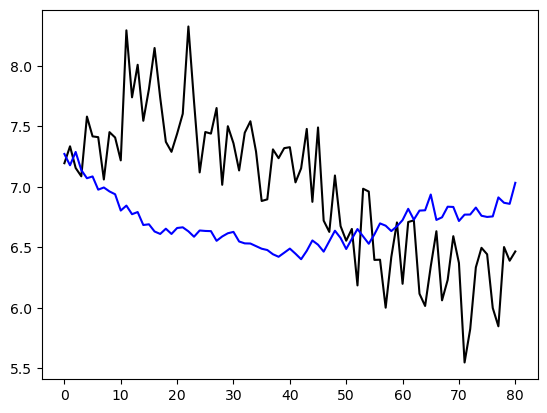

In [87]:
import matplotlib.pyplot as plt
plt.plot(obs[iassim], 'k')
plt.plot(Hk @ prior_mean_m, 'b')


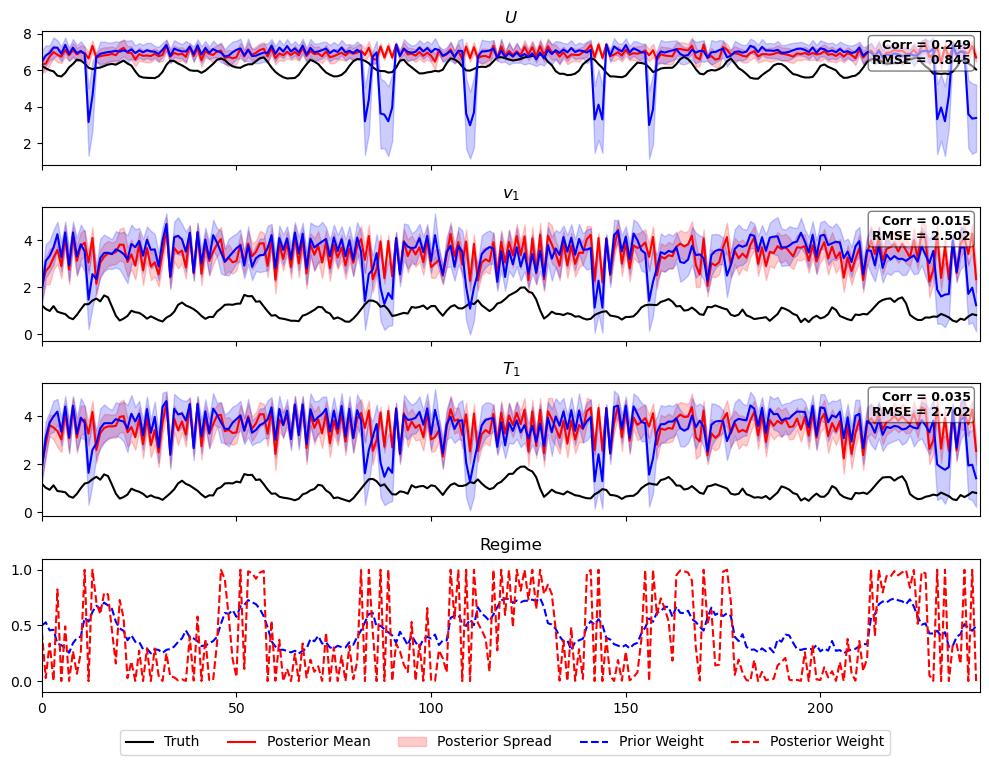

In [111]:
import matplotlib.pyplot as plt
from plot import plot_topobaro_series
ix = 60
plot_topobaro_series(dt_obs, 0, nobstime, 1, [truth[:,0,ix], truth[:,1,ix], truth[:,1, ix+1]], 
               np.concatenate((analy_mean_mixture[:, 0, ix:ix+1], analy_mean_mixture[:, 1, ix:ix+2]), axis=1),
               np.concatenate((analy_spread_mixture[:, 0, ix:ix+1], analy_spread_mixture[:, 1, ix:ix+2]), axis=1),
               prior_weights[:,1], posterior_weights[:,1], xlim=(0,241), warmup=40,
               prior_mean=np.concatenate((prior_mean_mixture[:, 0, ix:ix+1], prior_mean_mixture[:, 1, ix:ix+2]), axis=1),
               prior_spread=np.concatenate((prior_spread_mixture[:, 0, ix:ix+1], prior_spread_mixture[:, 1, ix:ix+2]), axis=1))
               # obs=np.concatenate((obs, np.full((Nt,1), np.nan)), axis=1))
# plt.savefig('../figure/series_2lstm_topobaro.png', bbox_inches='tight')

In [101]:
truth = truth_full * scales[None, :2, None]
analy = analy_mean_mixture * scales[None, :, None]

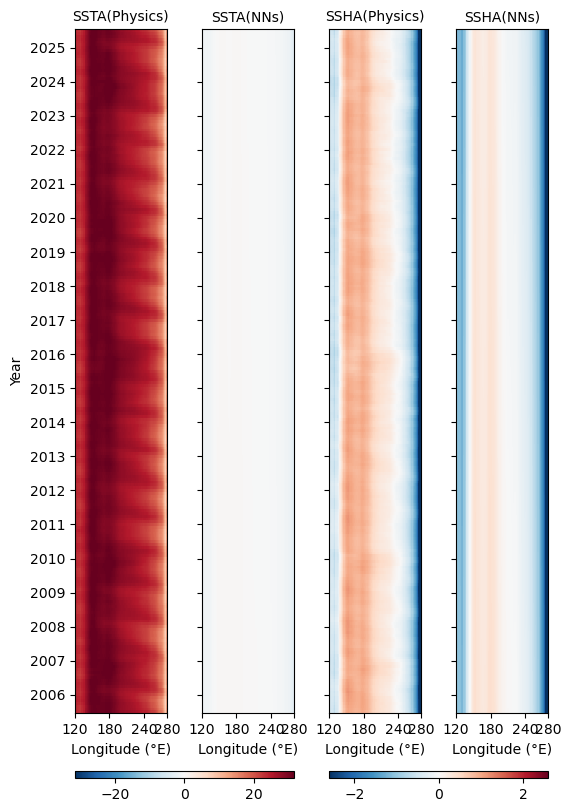

In [102]:
import matplotlib.pyplot as plt
from ENSO import Polynomial_Detrend
import numpy as np
import xarray as xr
import pandas as pd
ds = xr.open_dataset("../data/obs_sst_ssh_1d.nc")
time = pd.to_datetime(ds['time'].values)   # (T,)
lon  = np.asarray(ds['lon'].values)        # (Nx,)

# calculate anomalies of SST and SSH
t_points = np.arange((2005-1920)*12+7-1, (2025-1920)*12+7)
detrend_model = Polynomial_Detrend(degree=1).load("../model/detrend_cmip6_ACCESS-CM2_1d.npz") # Use observation fitted detrend model?
analy = np.zeros_like(truth)
for i in range(2):
    truth[:, i] = detrend_model.detrend(t_points, truth[:, i])
    analy[:, i] = detrend_model.detrend(t_points, analy[:, i])
    
var_names = ['ssta', 'ssha']
from plot import hovmoller_compare
hovmoller_compare(truth, analy, time, lon, var_names)
# plt.savefig('../figure/hovmoller_enso_cnnlstm_2regimes_cmip6_ACCESS-CM2_1d.png', dpi=150)
plt.show()

(0.0, 241.0)

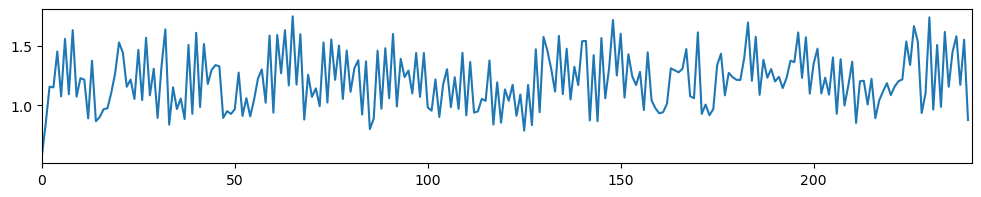

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,2))
plt.plot(np.arange(0 * dt_obs, 241 * dt_obs,  dt_obs), analy_rmse[:241,0,0])
plt.xlim(0,241)